# COMP0051 - Algo Trading CW1
### Hamza BC

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed, rand, uniform,normal
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from math import sqrt
import warnings
import scipy.stats
from scipy.stats import lognorm

## Section 1 - Timeseries Generation

array([ 0.        , -0.26805874,  0.4165947 ,  2.48540704])

Text(0, 0.5, 'Level $')

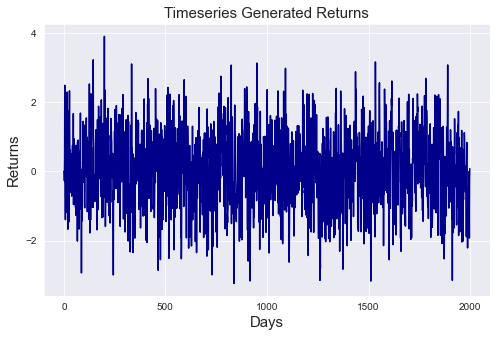

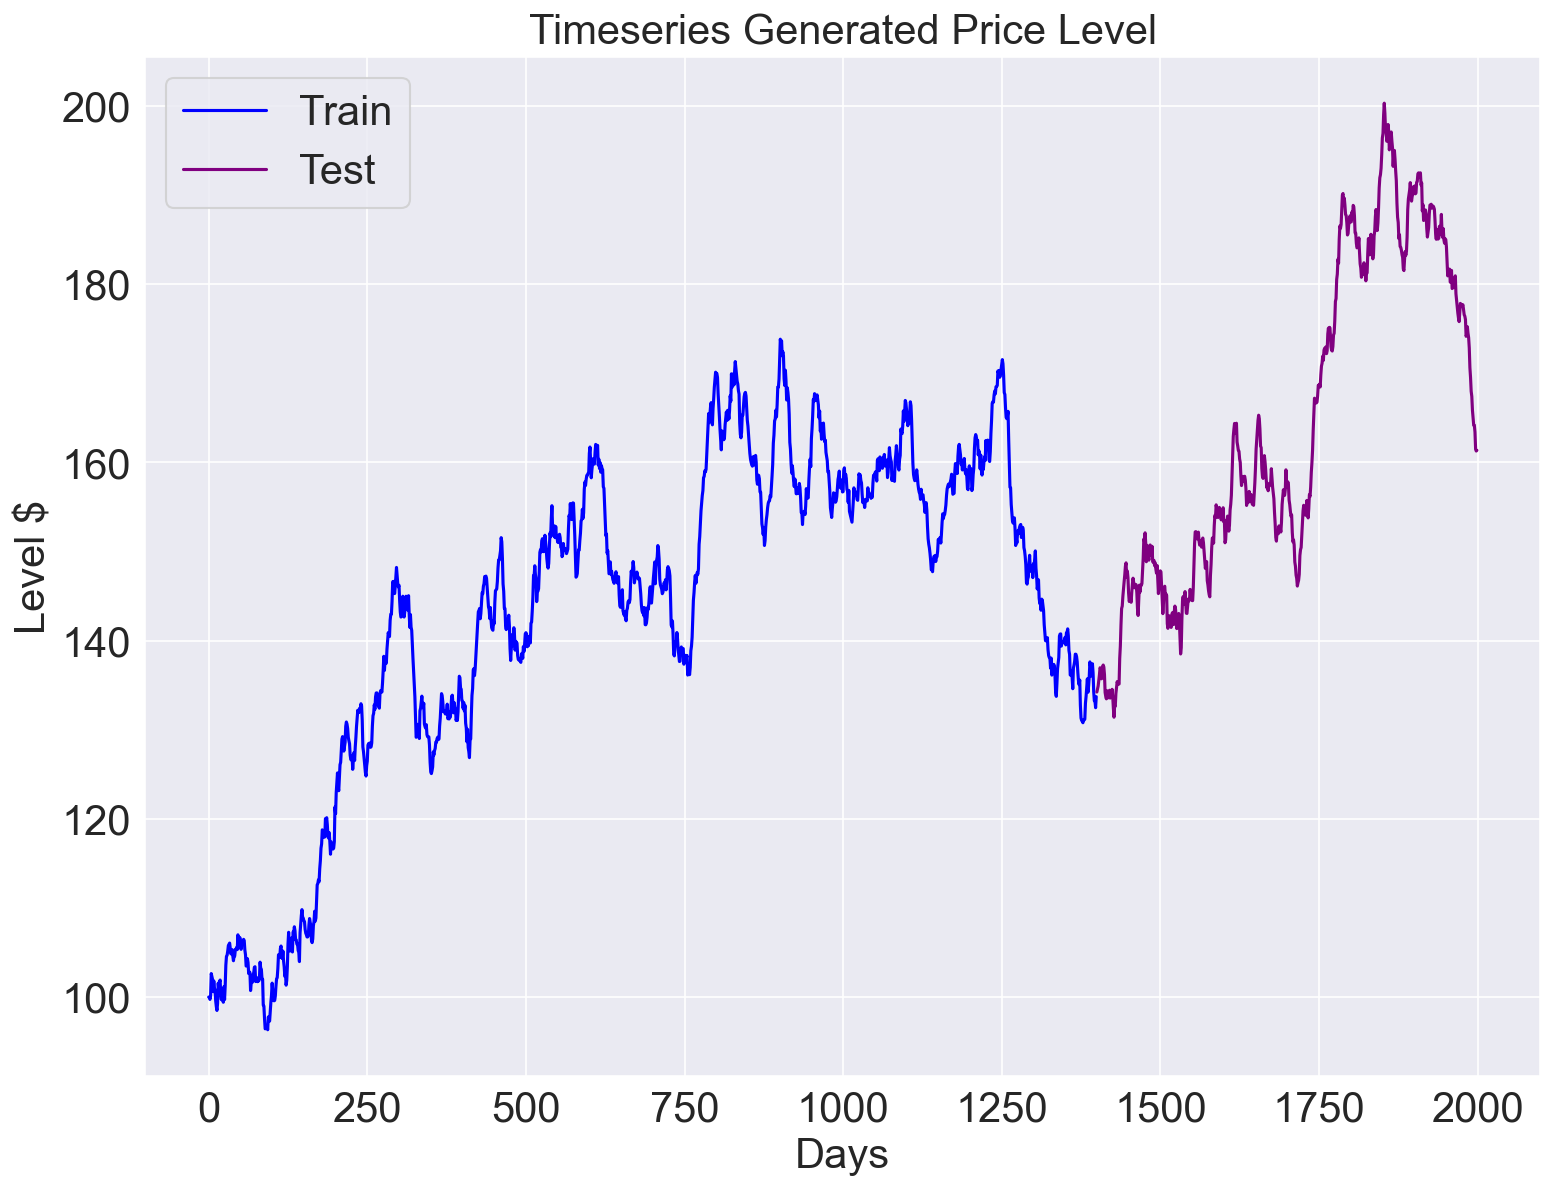

In [27]:
# Time Series Generation
%matplotlib inline

seed(200229610)    ## set seed to my student number

## Parameters of equation
t= range(0,2000)
y0 = 100
phi = 0.6
d = 0.025
theta = -0.4
epsilon = normal(0,1,2000)
y0 = 100
y1 = 100

## Generating the returns and level
dyt= np.zeros(np.shape(t))
dyt[0] = y1-y0

yt = np.zeros(np.shape(t))
yt[0] = y0; yt[1]=y1

for i in range(2,2000,1):
    dyt[i]= phi*(dyt[i-1]-d) + epsilon[i] + theta*epsilon[i-1]+d
    yt[i] = yt[i-1] + dyt[i]

display(dyt[1:5])

## Splitting into train & test 70/30 split
train, test = train_test_split(yt,test_size = 0.3,shuffle=False,random_state=200229610)

## Plotting 
plt.figure(figsize=(8,5))    
sns.set_style('darkgrid')
sns.lineplot(x=t,y=dyt,color='darkblue')
plt.title('Timeseries Generated Returns',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Returns',fontsize=15)

plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(12,9),dpi=150) 
sns.set_style('darkgrid')
# sns.lineplot(x=t,y=yt,color='blue')   ## sadly my beloved seaborn was fussier to use than matplotlib
plt.plot(train,color='blue',label='Train')
plt.plot([None for i in train] + [y for y in test],color='purple',label='Test')
plt.title('Timeseries Generated Price Level',fontsize=20)
plt.legend(loc='best')
plt.xlabel('Days',fontsize=20)
plt.ylabel('Level $',fontsize=20)


## Notes
The generated price leve seems to be fairly non-stationary. I'll confirm this later using an ADF test. It also seems to be reverting to the 35-50 range.

## It returns 60% over the sample... That will be hard to beat!

I'll start off with 3 strategies that I categorize as:
1) Indicator driven - Momentum / Risk Parity etc

2) 'Classical' Stat model based - ARIMAX, ECM, AR, MA ETC

3) ML based models - LTSM etc ( I did not end up doing this due to time constraints!)

As a first basis I'll estimate a MA-Cross strategy, then an appropriate classical stats model and lastly an LTSM.

I'll compare these to various baseline strategies such as buy and hold.


## Section 2 - Trading Strategies
### Part 1 - SMA Cross

I picked the SMA lengths by calling the strategy function for 'usual' suspects like the golden cross 50,200 EMA cross.
The optimal one below was one I utilised in my previous trading algos on MT4

,train_price_level
count,1400.000000
mean,143.027986
std,18.936989
min,96.328424
25%,133.046980
50%,146.919794
75%,157.901933
max,173.823172


,train_returns
count,1399.000000
mean,0.000236
std,0.007560
min,-0.028744
25%,-0.004407
50%,0.000002
75%,0.005311
max,0.033192


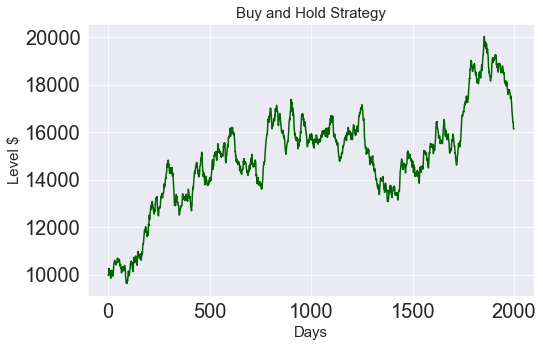

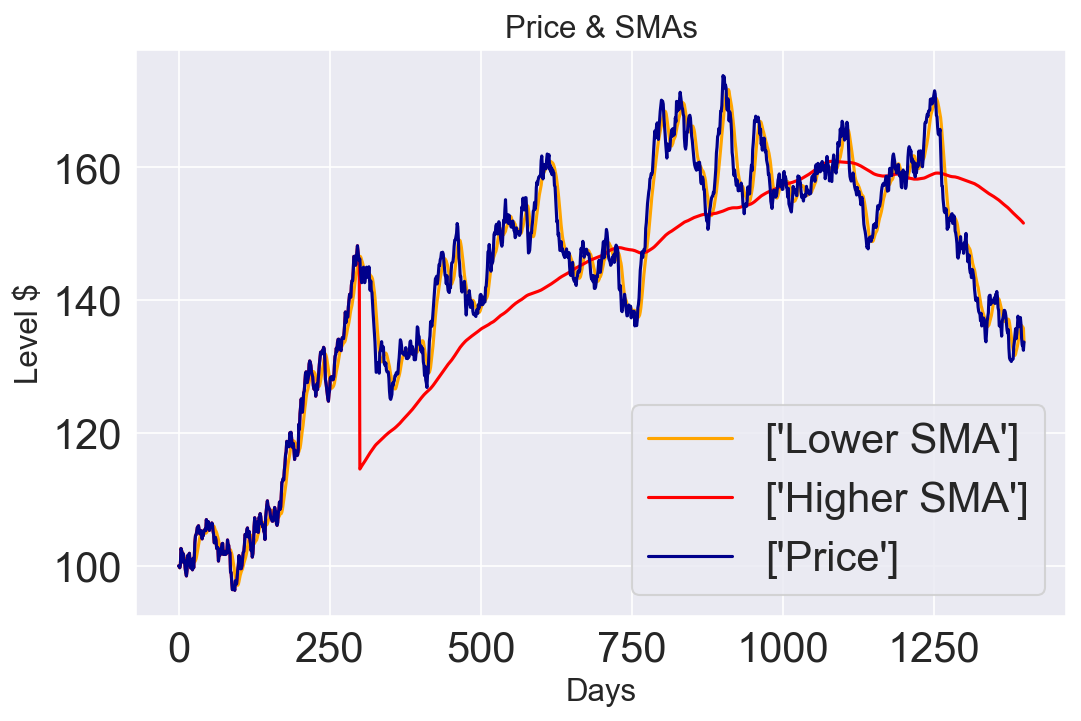

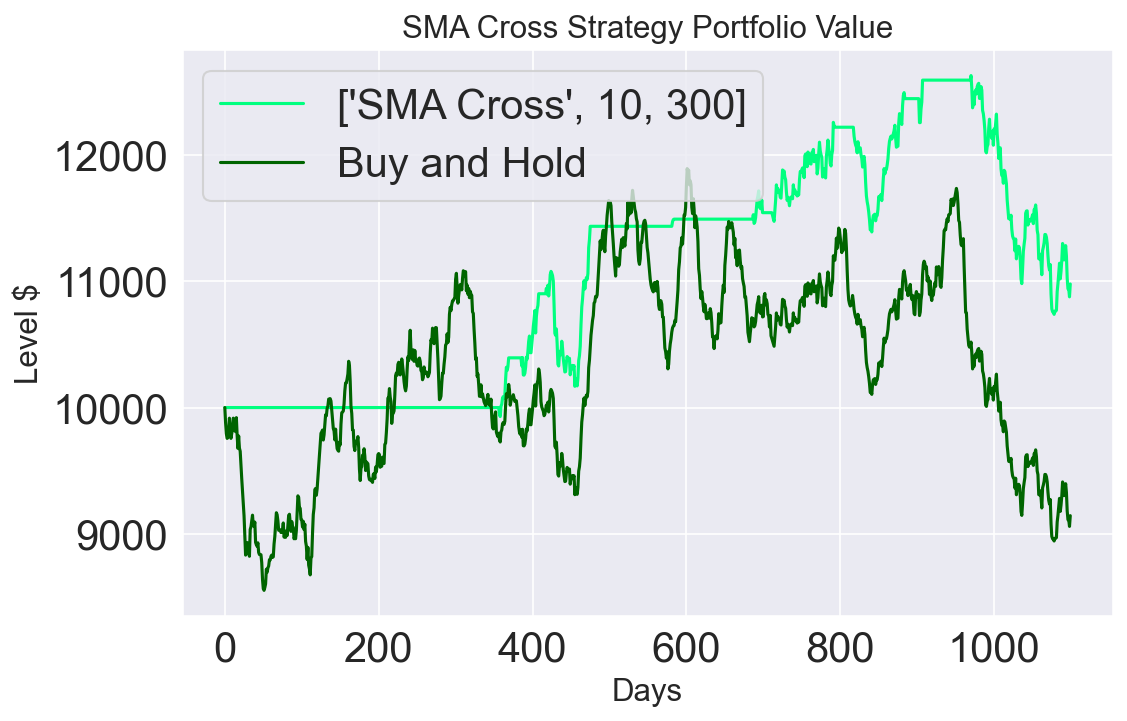

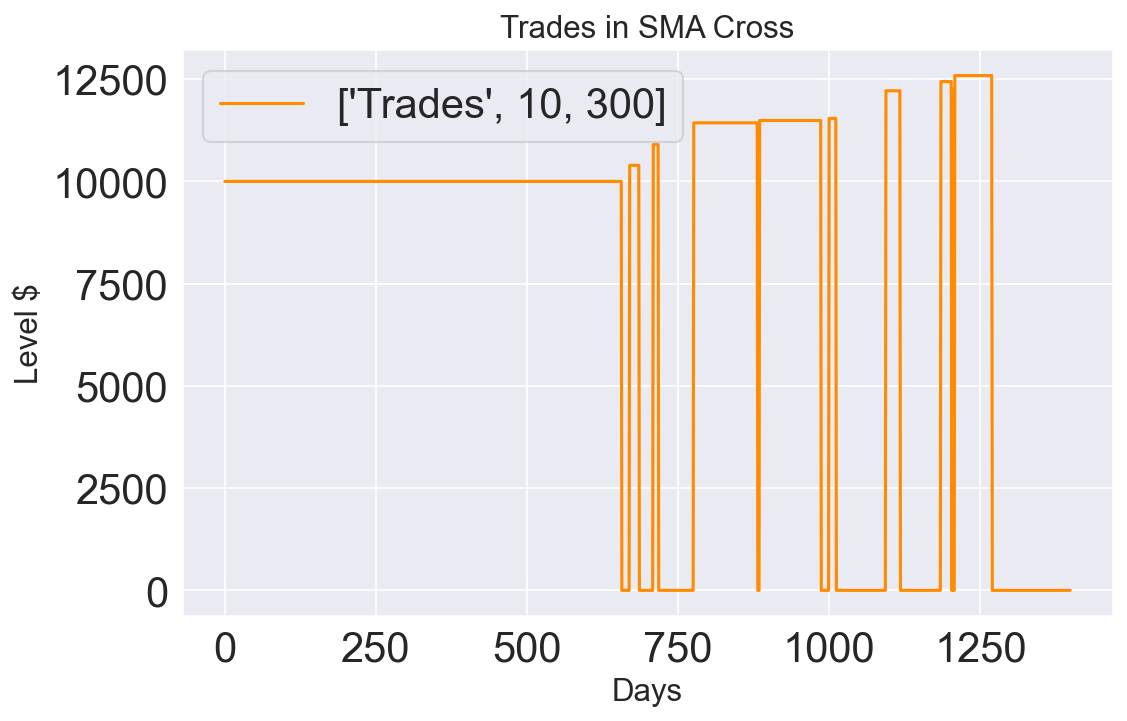

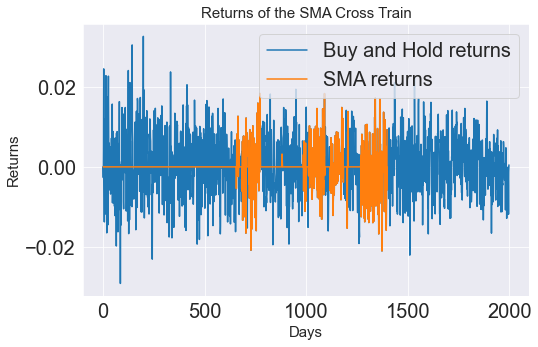

<Figure size 576x360 with 0 Axes>

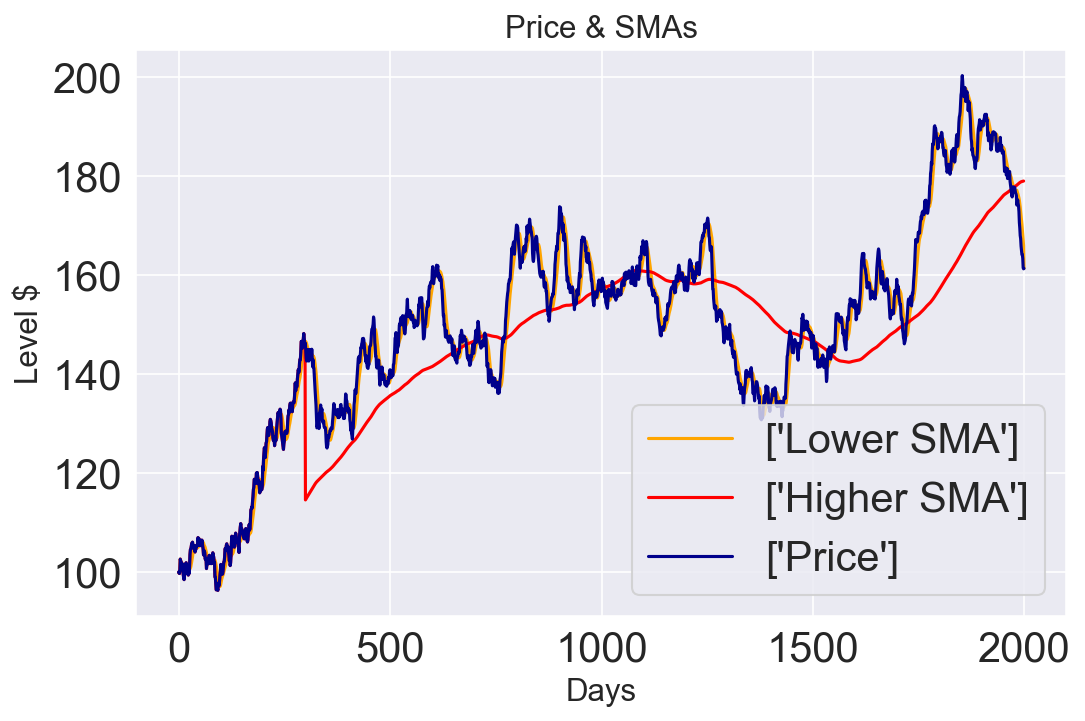

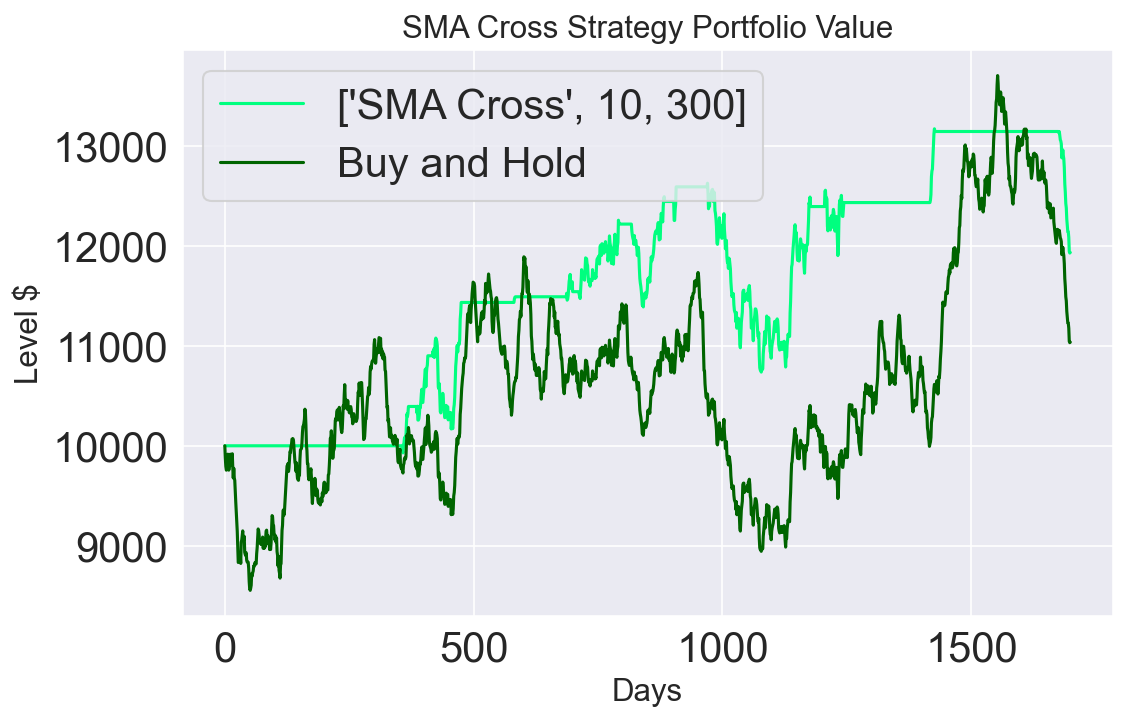

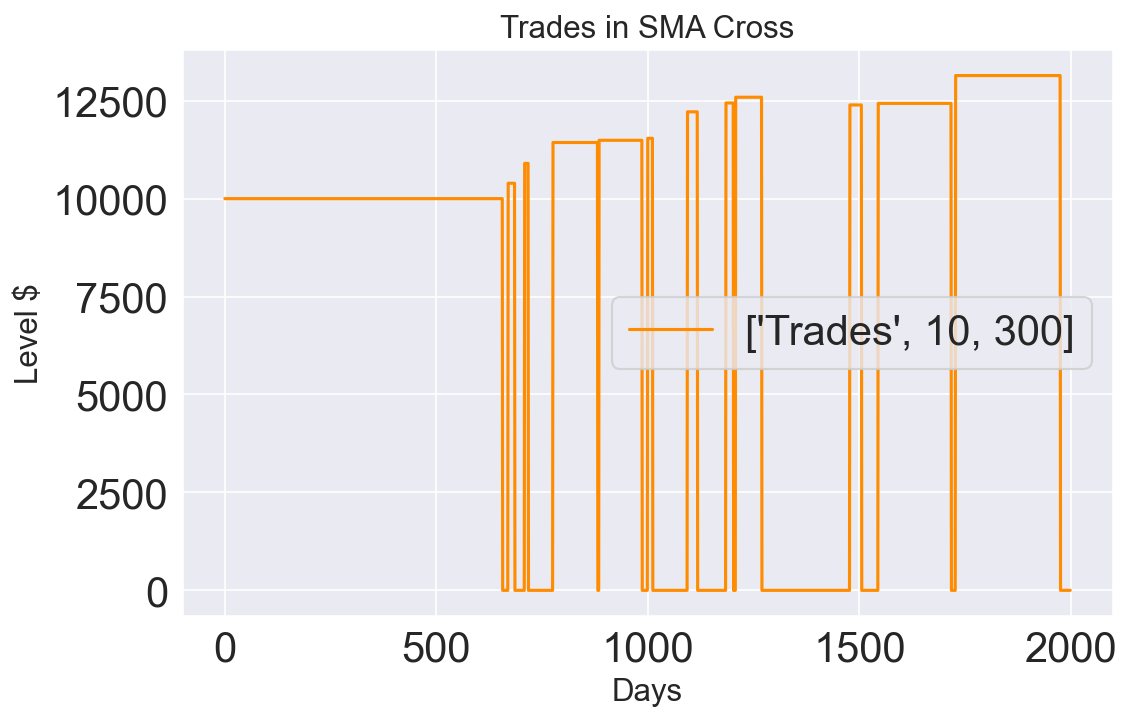

In [43]:
# Trading Strategy #1
cash = 10000

## Let's start by analysing the data a bit
df_price = pd.DataFrame(train,columns=['train_price_level'])
display(df_price.describe())

df_returns = pd.DataFrame(train,columns=['train_returns']).pct_change()   ## this is the same thing as dyt above
display(df_returns.describe()) 

## Buy & Hold benchmark
buy_hold =  cash*yt/yt[0]

plt.figure(figsize=(8,5)) 
sns.set_style('darkgrid')
plt.plot(buy_hold,color='darkgreen',label = 'Buy and Hold')
plt.title('Buy and Hold Strategy',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Level $',fontsize=15)


## Moving average cross - code adapted from lecture Jupyter notebooks

## Set up a function for ease

def MA(lower,higher,data):
    """
    lower = lower range of the MA
    higher = higher range of the MA
    data = specified array of dataset
    """
    
    ## Initialize some arrays
    ma_lower = np.zeros(np.shape(data))
    ma_higher = np.zeros(np.shape(data))
    ma_cash = np.zeros(np.shape(data))
    ma_cash[0] = cash
    tf = np.zeros(np.shape(data))  ## volume
    cumsum_l = [0]
    cumsum_h = [0]
    
    ## Algo for the MA cross
    for i, x in enumerate(data[:-1], 0):
        cumsum_l.append(cumsum_l[i] + x)
        cumsum_h.append(cumsum_h[i] + x)
        ma_lower[i] = x
        ma_higher[i] = x

        if i>=lower:
            moving_ave_lower = (cumsum_l[i] - cumsum_l[i-lower])/(lower)
            ma_lower[i] = moving_ave_lower

        if i>=higher:
            moving_ave_higher = (cumsum_h[i] - cumsum_h[i-higher])/(higher)
            ma_higher[i] = moving_ave_higher
            
        ma_cash[i+1] = ma_cash[i]
        
        if i >= higher:

            if ma_lower[i] == ma_higher[i]:
                tf[i+1] = tf[i]
                ma_cash[i+1] = ma_cash[i]

            elif ma_lower[i] < ma_higher[i]:      
                tf[i+1] = ma_cash[i]/x  + tf[i]
                ma_cash[i+1] = 0

            elif ma_lower[i] > ma_higher[i]:
                ma_cash[i+1] = tf[i]*x + ma_cash[i]
                tf[i+1] = 0

    ma_lower[i+1] = data[len(data)-1]
    ma_higher[i+1] = data[len(data)-1]

    tf_strategy = [a*b for a,b in zip(tf,data)]+ ma_cash
    
    ## Plots
    
    plt.figure(figsize=(8,5),dpi=150) 
    plt.plot(ma_lower,color='orange',label=['Lower SMA'])
    plt.plot(ma_higher[:-1],color='red',label=['Higher SMA'])
    plt.plot(data,color='darkblue',label=['Price'])
    plt.legend(loc='best')
    plt.title('Price & SMAs',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.show()
    
    plt.figure(figsize=(8,5),dpi=150) 
    plt.plot(tf_strategy[higher:],label=['SMA Cross',lower,higher],color='springgreen')
    plt.plot(cash*data[higher:]/data[higher],label='Buy and Hold',color='darkgreen')
    plt.legend(loc='best')
    plt.title('SMA Cross Strategy Portfolio Value',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.show()
    
    plt.figure(figsize=(8,5),dpi=150) 
    plt.plot(ma_cash,color='darkorange',label=['Trades',lower,higher])
    plt.legend(loc='best')
    plt.title('Trades in SMA Cross',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.show()
    
    
    
    return tf_strategy, ma_cash
    

# tf_strategy, ma_cash = MA(10,300,train)  ## this is one i used to use in older algos on MT4
# MA(50,200,train)  ## the so called golden cross
# MA(20,100,train)


## Create a function to get returns of a trading strategy

def returns(data):
    """
    data: array of total value of a strategy (portfolio value)
    """
    temp = np.log(data[1:] / data[:-1])
    return(temp)


## Algo estimation / optimisation over train set

tf_strategy, ma_cash = MA(10,300,train)

## to pick the best SMA lenghts, I estimated various combinations using the function for the TRAIN set only.
## the best performing SMA lengths over the train set was then picked, i increased the lower and higher SMAs in increments of 10 and 50 respectivley to identify the best lengths
## Here, performance refers to any combination of SMAs that beat the buy and hold strat over the train set


## Used for calculations later on
# tf_strategy, ma_cash = MA(10,300,yt)

## Plot

plt.figure(figsize=(8,5))
plt.plot(returns(buy_hold),label='Buy and Hold returns')
plt.plot(returns(tf_strategy),label='SMA returns')
plt.legend(loc='best')
plt.title('Returns of the SMA Cross Train',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Returns',fontsize=15)
plt.show()

plt.figure(figsize=(8,5))


## Estimate again over entire dataset just to overwrite the portfolio value
## This will be used for computing performance metrics later on
tf_strategy, ma_cash = MA(10,300,yt)

## Part 2 - Risk Parity

Risk Parity Vol 0.004162562226015891
Buy and Hold Vol 0.14902183009015837


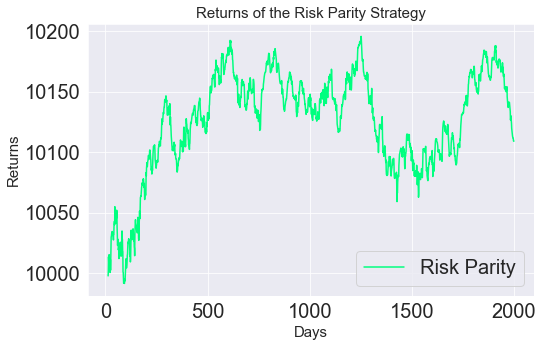

In [4]:
# For fun I'll do a risk-parity strategy too

## I had this code at hand from a personal project a few months back, adapted from: https://www.the905guy.ca/article/how-to-create-a-risk-parity-strategy-in-python
## it trades in every time step based on the volatility measure

## Max annual vol tolerance
max_vol = 0.25 ##

## biweekly vol
rp_vol = pd.DataFrame(yt).rolling(14).std()*np.sqrt(14) 

## Get the returns
rp_returns = pd.DataFrame(yt).pct_change()

## Portfolio weights
port_w_rp = (max_vol/rp_vol).dropna()   ## drop na to be safe


## Building df 

portfolio_returns = pd.DataFrame((rp_returns*port_w_rp).dropna())
portfolio_returns.columns=['return']

portfolio_returns = ((portfolio_returns['return']+1).cumprod())*cash

plt.figure(figsize=(8,5))
plt.plot(portfolio_returns, label = 'Risk Parity',color='springgreen')
plt.title('Returns of the Risk Parity Strategy',fontsize=15)
# plt.plot(buy_hold,color='darkgreen',label = 'Buy and Hold')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Returns',fontsize=15)
plt.legend(loc='best')
print('Risk Parity Vol',np.log(portfolio_returns).std())
print('Buy and Hold Vol',np.log(buy_hold).std())

## On the Risk Parity Strategy
In my experience, this strat typically works better over multiple asset classes.

Its just about returning 1% over the dataset. However, at least it minimized the volatility...

## Part 3 - ARIMA

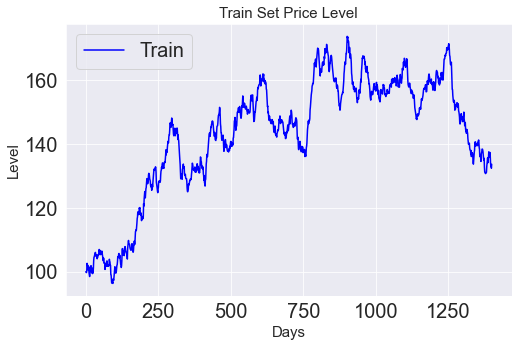

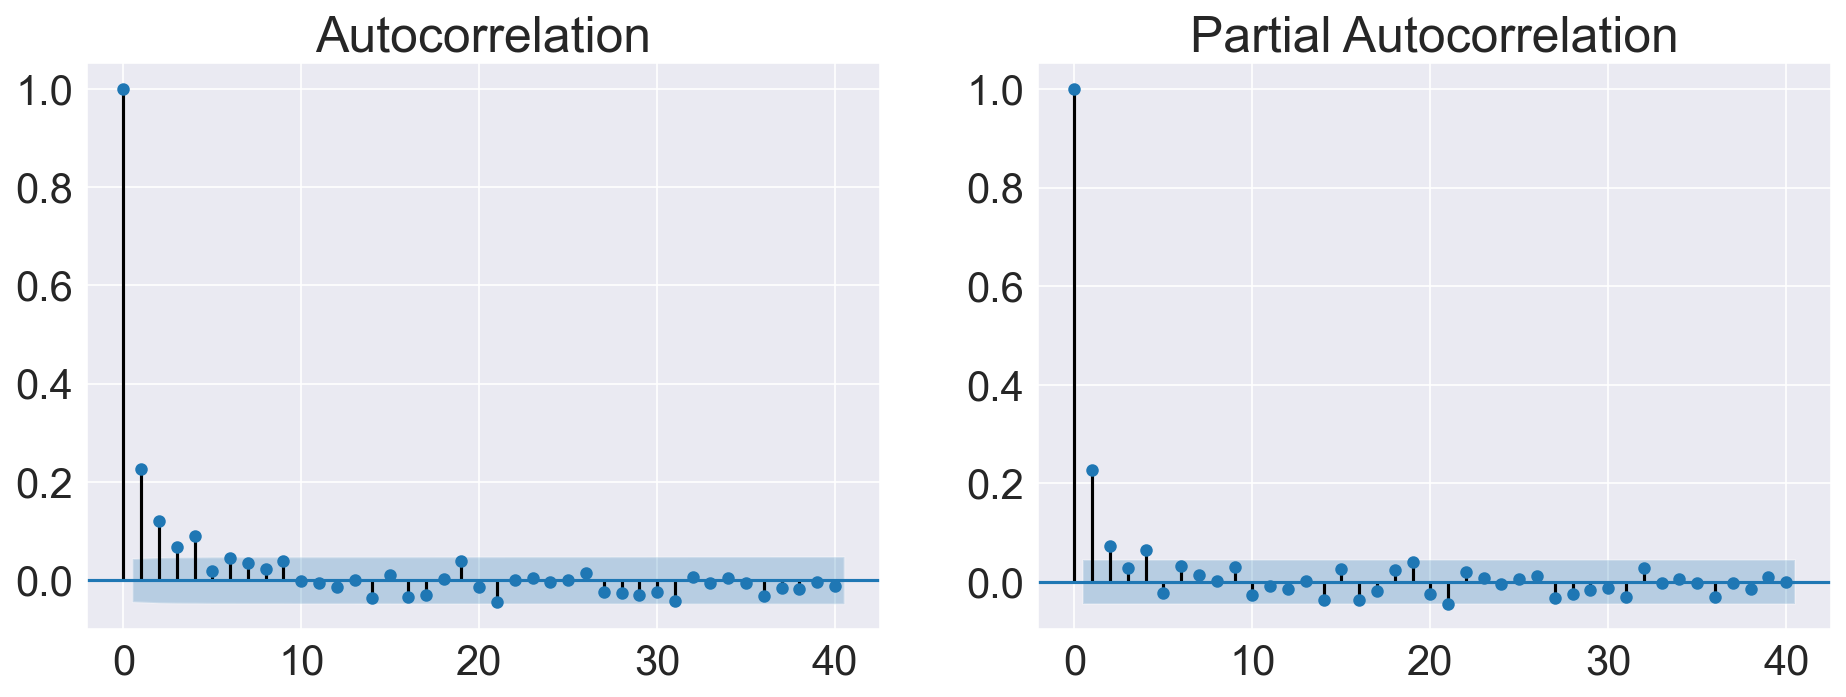

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1399
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -2023.675
Method:                       css-mle   S.D. of innovations              1.028
Date:                Wed, 03 Mar 2021   AIC                           4067.349
Time:                        11:20:31   BIC                           4119.784
Sample:                             1   HQIC                          4086.951
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0244      0.041      0.596      0.551      -0.056       0.105
ar.L1.D.y     -0.9331      0.652     -1.431      0.152      -2.211       0.345
ar.L2.D.y     -0.2207      0.376     -0.587      0.5

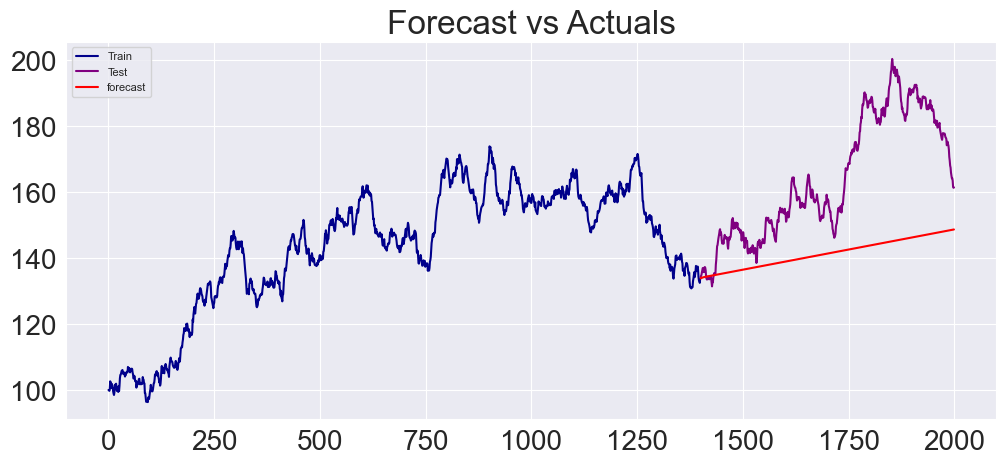

In [28]:
# Classical Stats Approach
# ARIMA, this requires some stat tests.
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

log_train = np.log(train)
log_test = np.log(test)

## Just eyeballing to see whether or not to include a constnat or trend in the ADF test
## Interestingly, most online articles about the ADF test we're implementing it incorrectly! 
plt.figure(figsize=(8,5)) 
sns.set_style('darkgrid')
plt.plot(train,color='blue',label='Train')
plt.title('Train Set Price Level',fontsize=15)
plt.legend(loc='best')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Level',fontsize=15)
plt.show()

## ADF Test - Constant & Trend

adfuller(train,regression="ct") ## this uses AIC to determine the lag length, Im happy with that!
## TS < CVs therefore not stationary. As expected by just looking at the chart!

## Test the return data
adfuller(dyt,regression="c")  ## As expected the returns (first difference) is indeed stationary!

## Let's Build an ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
# from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## ACF & PCAF
fig, axes = plt.subplots(1, 2, figsize=(15,5),dpi=150)
fig = sm.graphics.tsa.plot_acf(dyt, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(dyt, lags=40, ax=axes[1])
plt.show()

## Train model & set params based on ACF and PACF
model_1 = ARIMA(train, order=(4,1,4)) 
model_train_fit = model_1.fit() # stationarity can be checked here. We don't
print(model_train_fit.summary())

## make predictions from start of sample onwards. 
predictions = model_train_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True,typ='levels')
error = sqrt(mean_squared_error(test, predictions))


print('Train RMSE: %.3f' % error)

# Make as pandas series
fc_series = pd.Series(predictions)

# Plots
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train,color='darkblue',label='Train')
# plt.plot(model_train_fit.fittedvalues, color='red')


plt.figure(figsize=(12,5), dpi=100)
plt.plot(train,color='darkblue',label='Train')
plt.plot([None for i in train] + [y for y in test],color='purple',label='Test')
plt.plot([None for i in train]  + [x for x in fc_series],color='red',label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [6]:
# import pmdarima as pm
# # # !pip install pmdarima

## A stepwise approach to estimating the (p,q,d). I dont like this approach for various reasons. 
## However it suggests that there should be no AR components! So i'll try out an MA model next!

# model = pm.auto_arima(train, start_p=1, start_q=1,start_d=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=6, max_q=6,max_d = 1, # maximum p and q
#                       m=150,
#                       d=None,         # let model determine 'd'
#                       seasonal=True,   # No Seasonality
#                       start_P=0, 
#                       D=None, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(model.summary())

# model.plot_diagnostics(figsize=(12,5))
# plt.show()

# # Forecast
# fc, conf = model.predict(n_periods=len(test), return_conf_int=True,dynamic=True)  # 95% conf

# # Make as pandas series
# fc_series = pd.Series(fc, index=test)

# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train,color='darkblue',label='Train')
# plt.plot([None for i in train] + [y for y in test],color='purple',label='Test')
# plt.plot([None for i in train]  + [x for x in fc_series],color='red',label='forecast')
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

## Notes on ARIMA

The roots are not stable, similarly the model clearly suffers to adiquitely capture the non-stationary elements.

I'll be scrapping this one!

## Part 4  - AR

Lag: 23
Test AutoAR RMSE: 0.007
Test Dep. RMSE: 0.007


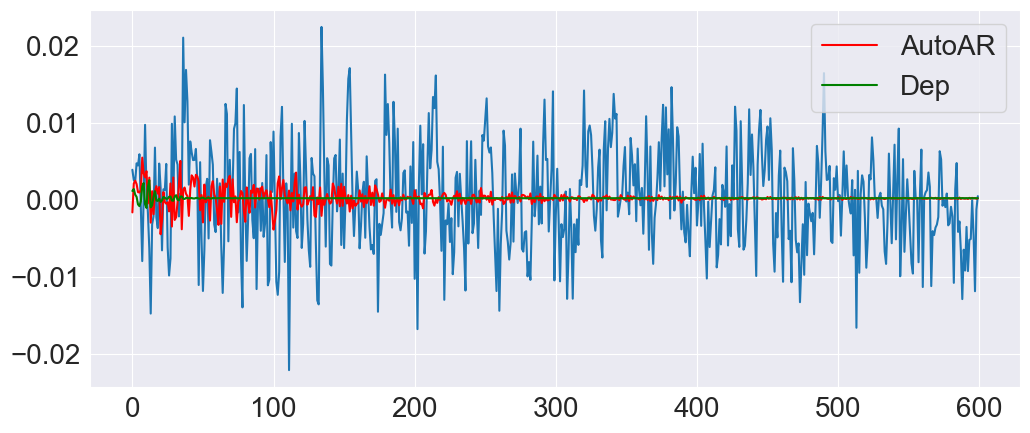

In [7]:
# AR Approach
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

## Splitting into train & test 70/30 split
d_train, d_test = train_test_split(returns(yt),test_size = 0.3,shuffle=False,random_state=200229610)


# Depricated AR model, I picked the lag order based on the plots
model_dep = AR(d_train)
model_fit_dep = model_dep.fit()
predictions_dep = model_fit_dep.predict(start=len(d_train), end=len(d_train)+len(d_test)-1, dynamic=False)
error_dep = mean_squared_error(d_test, predictions_dep)
print('Lag: %s' % model_fit_dep.k_ar)


# Auto AR
model = AutoReg(d_train,lags=150)
model_fit = model.fit()

predictions = model_fit.predict(start=len(d_train), end=len(d_train)+len(d_test)-1, dynamic=False)
error = mean_squared_error(d_test, predictions)

print('Test AutoAR RMSE: %.3f' % sqrt(error))
print('Test Dep. RMSE: %.3f' % sqrt(error_dep))

# plot results
plt.figure(figsize=(12,5), dpi=100)
plt.plot(d_test)
plt.plot(predictions, color='red',label='AutoAR')
plt.plot(predictions_dep, color='green',label='Dep')
plt.legend(loc='best')
plt.show()



Text(0, 0.5, 'Level')

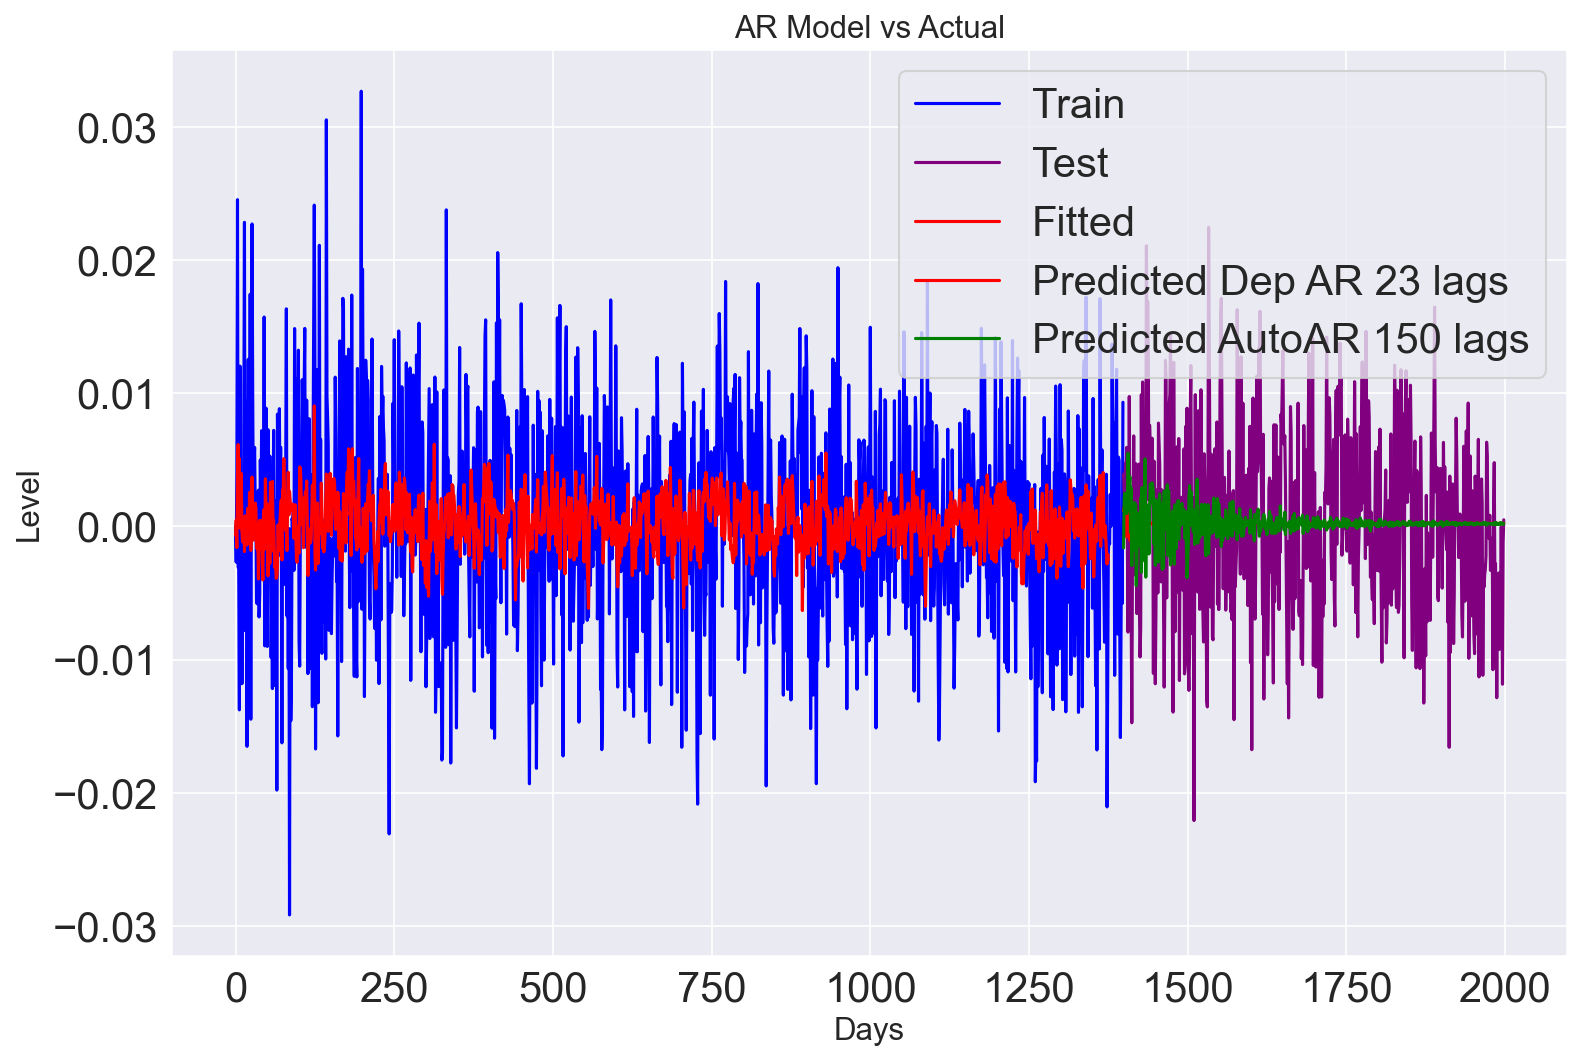

In [8]:
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train,color='darkblue',label='Train')
# plt.plot(model_fit.fittedvalues, color='red')
# plt.plot(model_fit_dep.fittedvalues, color='green')

plt.figure(figsize=(12,8), dpi=150) 
sns.set_style('darkgrid')
plt.plot(d_train,color='blue',label='Train')
plt.plot([None for i in d_train] + [y for y in d_test],color='purple',label='Test')
plt.plot(model_fit_dep.fittedvalues,color='red',label='Fitted')
plt.plot([None for i in d_train] + [y for y in predictions_dep],color='red',label='Predicted Dep AR 23 lags')
plt.plot([None for i in d_train] + [y for y in predictions],color='green',label='Predicted AutoAR 150 lags')
plt.title('AR Model vs Actual',fontsize=15)
plt.legend(loc='best')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Level',fontsize=15)


## NOTE For Self:
Python's Statsmodels lib produces the characteristic roots of the polynomial in the summary!!!!!!!

NOT THE INVERSE. Therefore, the ARIMA was indeed stationary and I spent far too long racking my brain over that... I miss Eviews

https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ARResults.roots.html#statsmodels.tsa.ar_model.ARResults.roots

In [25]:
## Produce Algo Equivalent AR Model

AR_algo_testing = AR(dyt[:300])
AR_algo_testing_fit = AR_algo_testing.fit(ic='hqic')

AR_algo_testing_fit.summary()

## Roots are greater than 1 and lie outside the unit circle, therefore the AR model is stationary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:                          AR(1)   Log Likelihood                -419.895
Method:                          cmle   S.D. of innovations              0.985
Date:                Wed, 03 Mar 2021   AIC                             -0.009
Time:                        10:43:23   BIC                              0.028
Sample:                             0   HQIC                             0.006
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1344      0.058      2.323      0.020       0.021       0.248
L1.y           0.1256      0.058      2.180      0.029       0.013       0.238
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.9633           +0.0000j            7.9633            0.0000
-----------------------------------------------------------------------------
"""

## Conclusion

I like the depricated version! But it doesnt make a difference as I can specify the lags in the new version too.

The depricated version, in the context of live trading, can be fairly useful and extremeley scary...
the way i have it setup, it will restimate the models optimal lag length based on HQC for each time step greater than the time window of 300.

I find this pretty cool but also terrifying... 

for every i > 300 up to length(train set) , the AR model is evaluating the lag length and potentially changing it each timestep. However, some papers find that as the sample size increases, HQC correctly picks the lag length correclty over over methods.

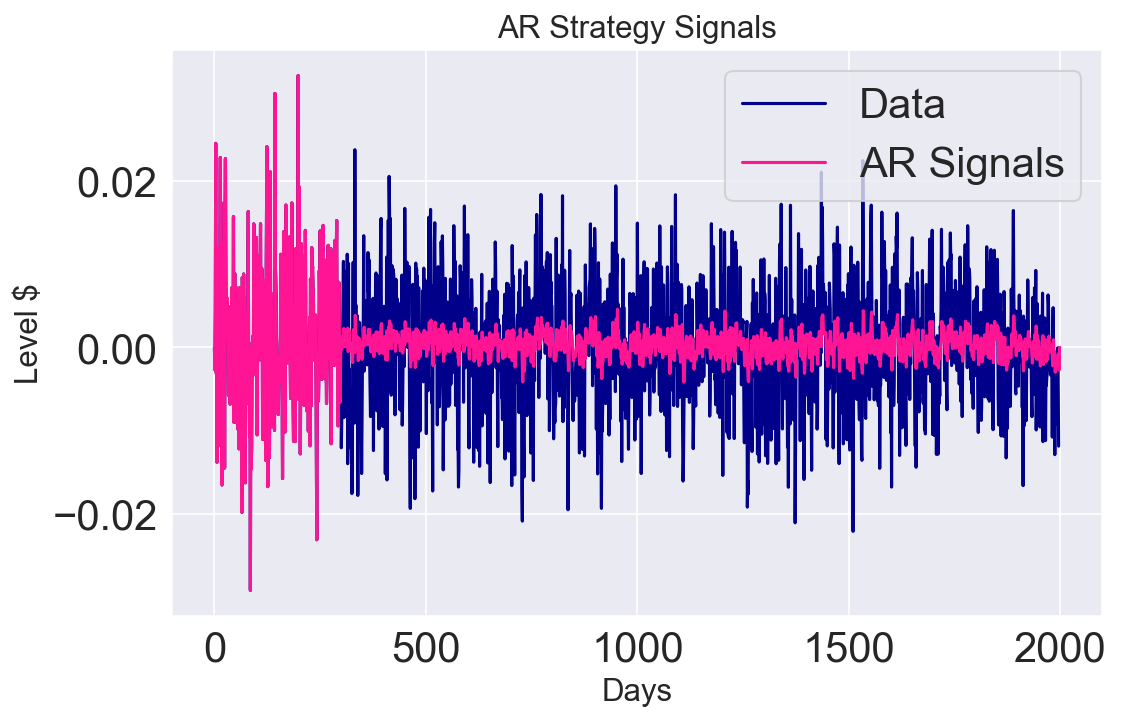

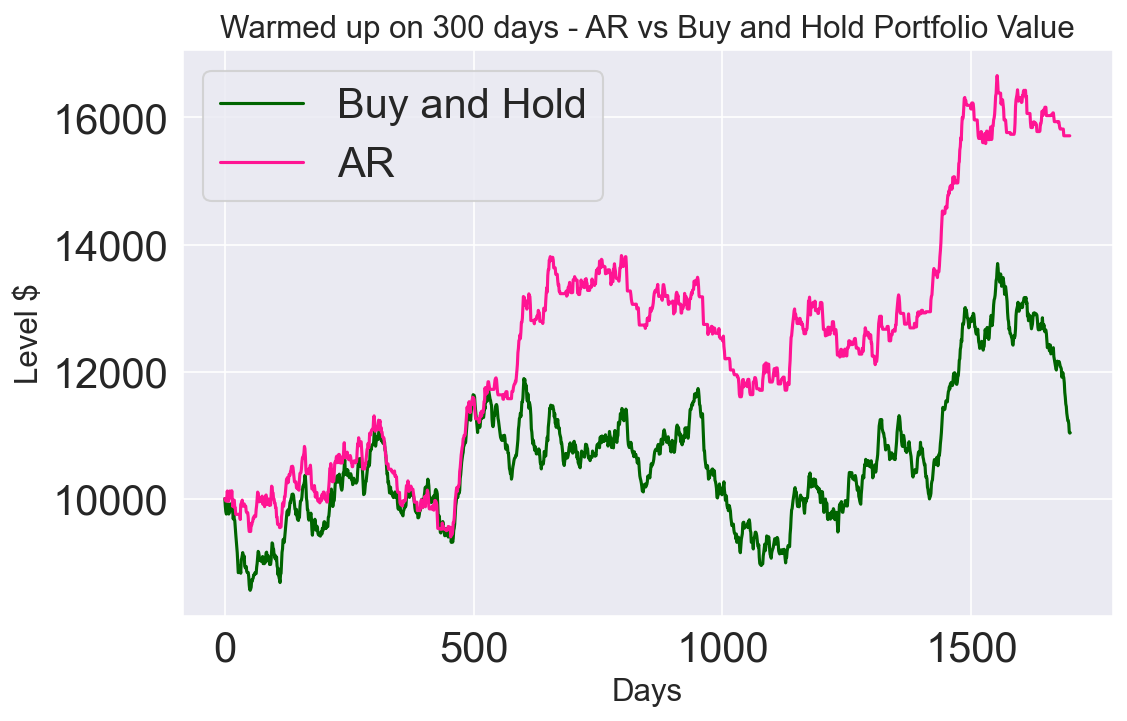

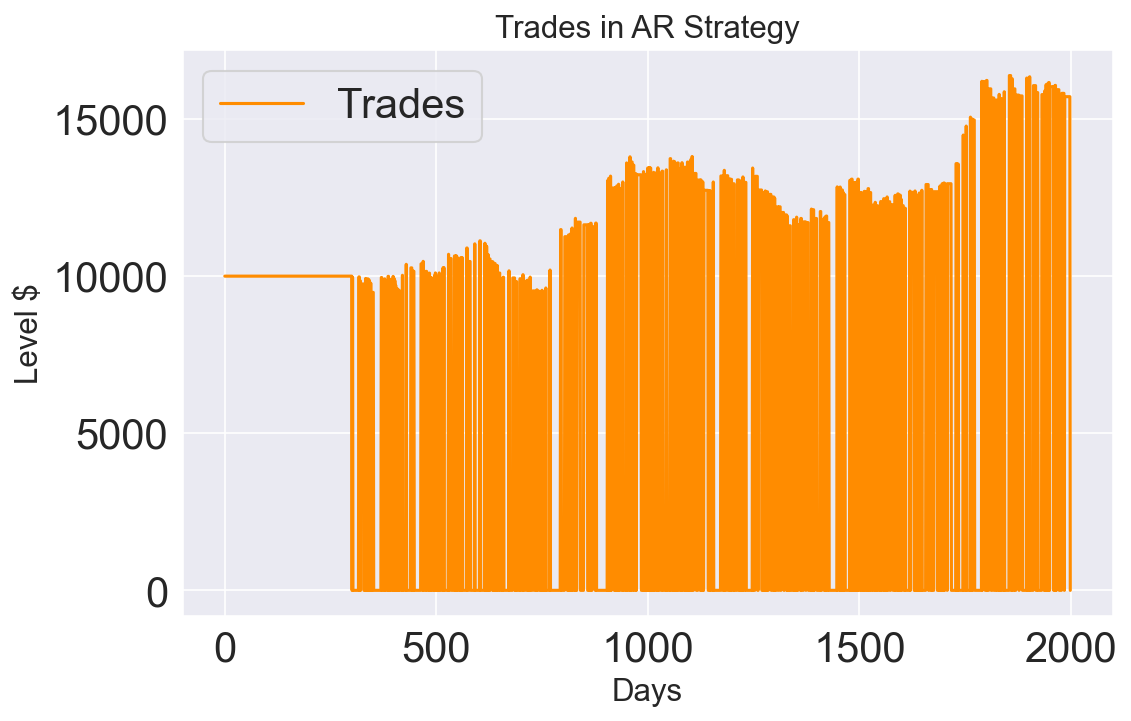

In [32]:
#TRADING: AR 

def AR_strat(levels_data):
    warnings.filterwarnings('ignore')

    time_window = 300
    cumsum_ar = [0]

    ar_prediction = np.zeros(np.shape(levels_data))
    w_ar = np.zeros(np.shape(levels_data))
    cash_ar = np.zeros(np.shape(levels_data))
    cash_ar[0] = cash
    ret = returns(levels_data)
    price_level = levels_data[1:]

    for i, x in enumerate(ret):

        if i == len(ret)-1:
            break

        ar_prediction[i] = x

        if i>=time_window:
            data = ret[0:i]
            train_ar = data

            # train autoregression
            model = AR(train_ar)
            model_fit = model.fit(ic='hqic')

            predictions = model_fit.predict(start=len(train_ar), end=len(train_ar), dynamic=False)
            ar_prediction[i] = predictions[0]

        if ar_prediction[i] == x:
            w_ar[i+1] = w_ar[i]
            cash_ar[i+1] = cash_ar[i]

        elif ar_prediction[i] > 0: 
            w_ar[i+1] = cash_ar[i]/price_level[i+1]  + w_ar[i]
            cash_ar[i+1] = 0

        elif ar_prediction[i] < 0:
            cash_ar[i+1] = w_ar[i]*price_level[i+1] + cash_ar[i]
            w_ar[i+1] = 0



    ar_strategy = [a*b for a,b in zip(w_ar[:-1],price_level)]+ cash_ar[:-1]

    plt.figure(figsize=(8,5),dpi=150)
    plt.plot(data,color='darkblue',label = 'Data')
    plt.plot(ar_prediction,label='AR Signals',color='deeppink')
    plt.title('AR Strategy Signals',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.legend(loc='best')
    plt.show()
    
    
    plt.figure(figsize=(8,5),dpi=150)
    plt.plot(cash*levels_data[time_window:]/levels_data[time_window],color='darkgreen',label = 'Buy and Hold')
    plt.plot(ar_strategy[time_window:],label='AR',color='deeppink')
    plt.title('Warmed up on 300 days - AR vs Buy and Hold Portfolio Value',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(8,5),dpi=150) 
    plt.plot(cash_ar,color='darkorange',label='Trades')
    plt.legend(loc='best')
    plt.title('Trades in AR Strategy',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.show()
    
    return ar_strategy, cash_ar

## Whole sample 

ar_strategy, cash_ar = AR_strat(yt)

## Why I'm not estimating an LTSM or NN

My prior hypothesis is that there will undoublty be data leakage.

The autocorrelations of the timeseries will be fed into the NN and the model would then 'see' these strucutres in the back propagation such that it effectiley amounts to data leakage.

I'm also running low on time and foresee the hyperparam tuning to take a while...

## Part 5 -  exponential smoothing
### Simple exp smoothing

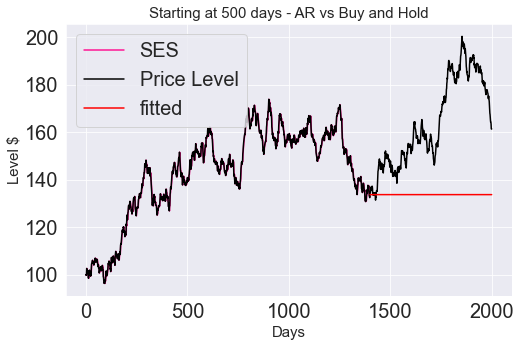

In [10]:
# Simple Exponential Smoothing - holt winters method

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as SES

## Estiamte model
model = SES(train)
model_fit = model.fit()

## Predict
# yhat = model_fit.predict(start=len(train), end=len(train))
fit = model_fit.forecast(len(test))

plt.figure(figsize=(8,5))
plt.plot(model_fit.fittedvalues,label='SES',color='deeppink')
plt.plot(yt,label='Price Level',color='black')
plt.plot([None for i in train] + [y for y in fit],color='red',label='fitted')

plt.title('Starting at 500 days - AR vs Buy and Hold',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Level $',fontsize=15)
plt.legend(loc='best')
plt.show()

## Not great. Its a bit like the ARIMA
# Lets try adding seaasonal smoothing!

## This might be cheating...

I know how the time series is generated. Similarly, I have identified a rough seasonal trend every 100 - 250 'days'. Every 100 days or so the data changes direction. 

I can exploit these directional shifts using seasonal exponential smoothing

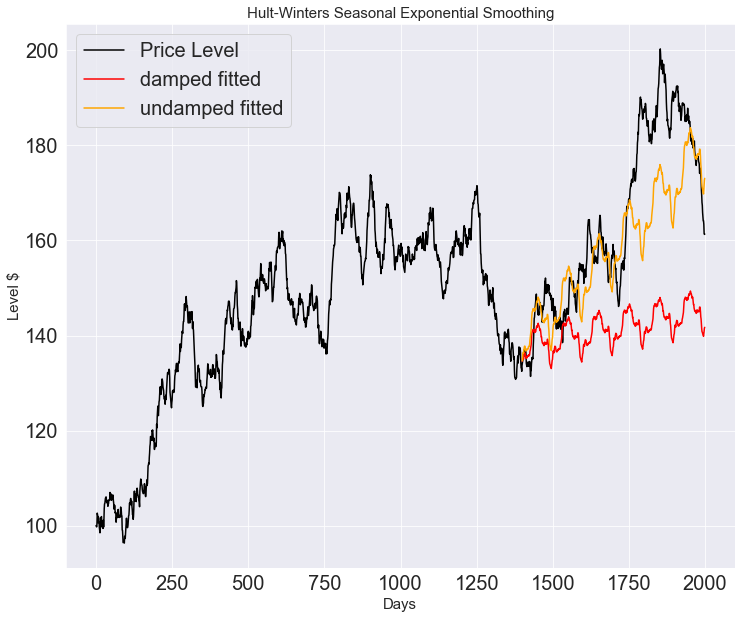

In [11]:
# Estiamte model

## Damped, for some reason the damping only works on my PC and not laptop. I suspect this is a version control thing...
model_damped = HWES(train,seasonal_periods =100,trend='add', seasonal='add')#,damped_trend=True)
model_fit_damped = model_damped.fit()

## Undamped
model = HWES(train,seasonal_periods =100,trend='Multiplicative', seasonal='Multiplicative')
model_fit = model.fit()

## Predict

fit_damped = model_fit_damped.forecast(len(test))
fit = model_fit.forecast(len(test))

plt.figure(figsize=(12,10))
plt.plot(yt,label='Price Level',color='black')
plt.plot([None for i in train] + [y for y in fit_damped],color='red',label='damped fitted')
# plt.plot(model_fit_damped.fittedvalues,label='damped',color='red',ls='dotted',alpha=0.5)
# plt.plot(model_fit.fittedvalues,label='undamped',color='orange',ls='dotted',alpha=0.5)
plt.plot([None for i in train] + [y for y in fit],color='orange',label='undamped fitted')


plt.title('Hult-Winters Seasonal Exponential Smoothing',fontsize=15)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Level $',fontsize=15)
plt.legend(loc='best')
plt.show()


# The damped fit seems to fo quite well!

(0.844642945256924, 2.005347063921729e-164)

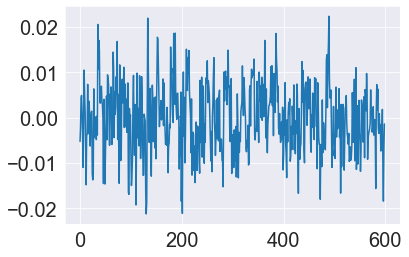

In [12]:
# plt.plot(returns(test))
# plt.plot(returns(fit))

plt.plot(returns(test) - returns(fit))

scipy.stats.pearsonr((test),(fit))


## It'll be a bit fussy to trade this so I'll set it aside for now.

## But it looks promising!

I'll be using the damped version!

note for later:
I could tell it to trade based on the sign of the t+1 forecast.
Or trade on the sign of the return

Compute the returns for each.

* I did not end up completing this due to a lack of time!*

In [13]:
# warnings.filterwarnings('ignore')
    
# time_window = 1000
# exp_prediction = np.zeros(np.shape(yt))
# w_exp = np.zeros(np.shape(yt))
# cash_exp = np.zeros(np.shape(yt))
# cash_exp[0] = cash
# price_level = yt[1:]
# ret = returns(yt)

# for i, x in enumerate(ret):
    
#     #exp_prediction[i] = x
#     if len(ret)-1 == 1997:
#         break
#   #  if i>=time_window:
#     data = yt[0:i]
#     train_exp = data

#     # train model over enture train set of data
#     model = HWES(train,seasonal_periods =100,trend='mul', seasonal='mul')
#     model_fit = model.fit()
    
#     ## Create forecasts over the length of the rest set
#     predictions = model_fit.forecast(len(test))
#     exp_prediction[i] = (predictions[0]) 
    
#     ## If the return on the prediction is +Ve buy
#     ## If -Ve hold (sell)
#     if exp_prediction[i] == x:
#         w_exp[i+1] = w_exp[i]
#         cash_exp[i+1] = cash_exp[i]
    
#     elif exp_prediction[i] > 0: 
#         w_exp[i+1] = cash_exp[i]/price_level[i+1]  + w_exp[i]
#         cash_ar[i+1] = 0
        
#     elif exp_prediction[i] < 0:
#         w_exp[i+1] = w_exp[i]*price_level[i+1] + cash_exp[i]
#         w_exp[i+1] = 0



# exp_strategy = [a*b for a,b in zip(w_exp,yt)]+ cash_exp

# plt.figure(figsize=(8,5))
# plt.plot(cash*yt/yt[0],color='darkgreen',label = 'Buy and Hold')
# plt.plot(exp_strategy,label='Exp Smoothing Strategy',color='red')
# plt.title('Exp Smoothing vs Buy and Hold',fontsize=15)
# plt.xlabel('Days',fontsize=15)
# plt.ylabel('Level $',fontsize=15)
# plt.legend(loc='best')
# plt.show()

## Part 6 - Mean Reversion (based sorta on the seaasonality length above)

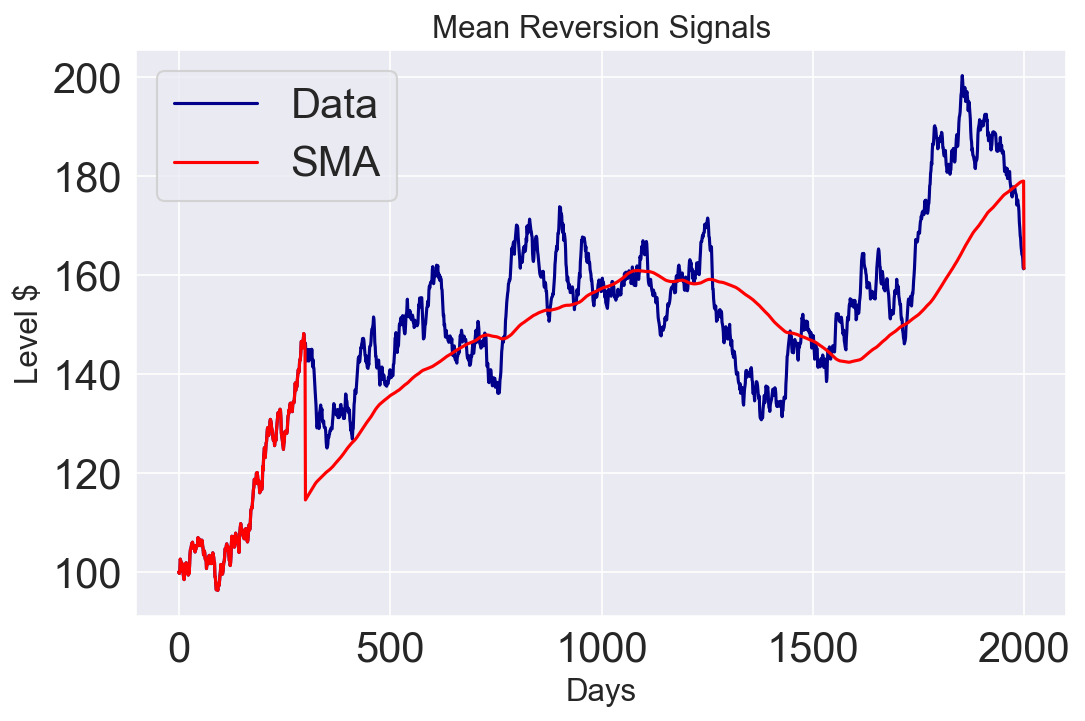

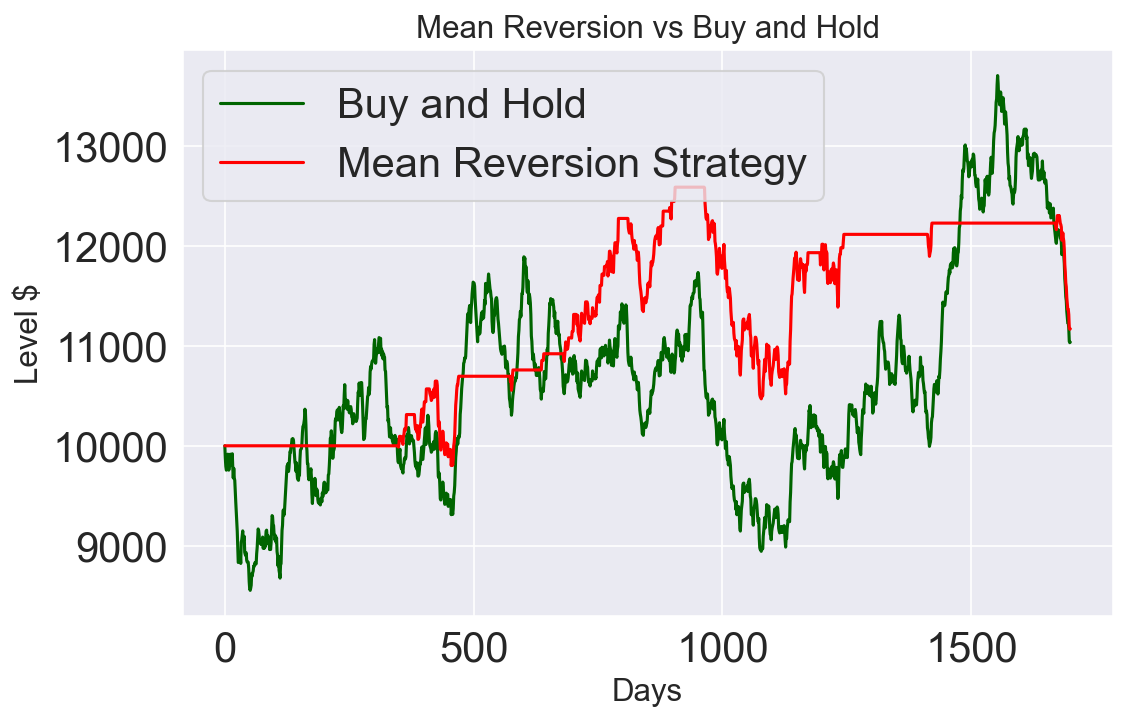

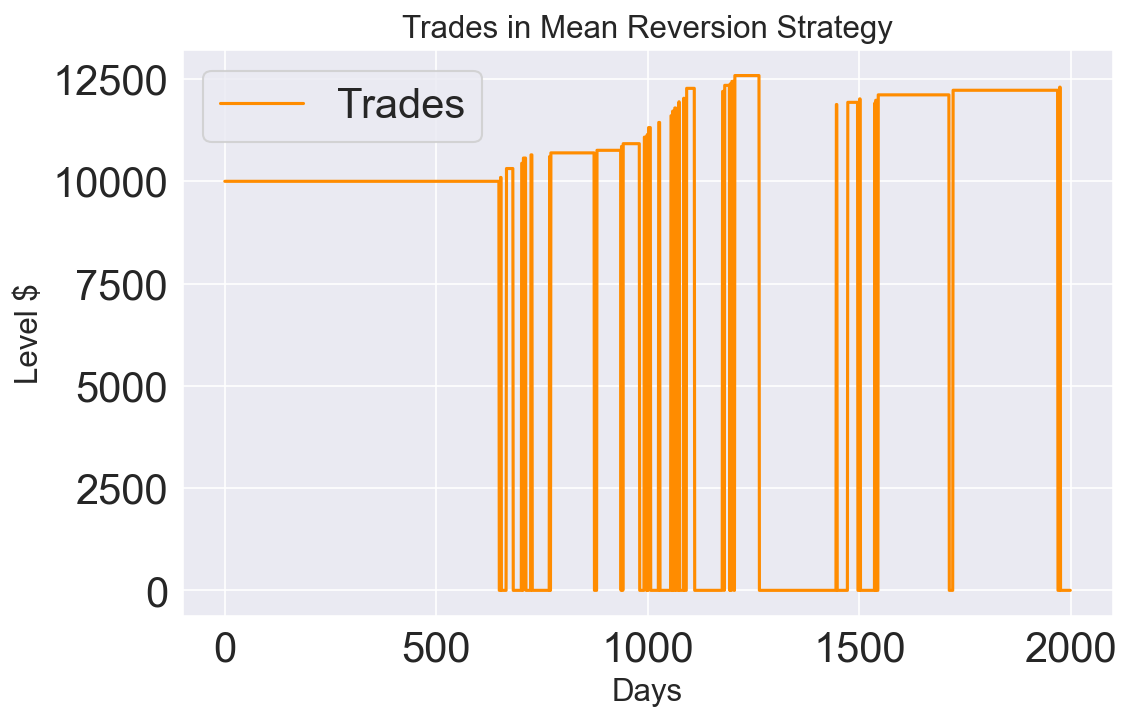

In [33]:
# Mean Reversion Strategy

def MR_strat(levels_data):
    
    time_window = 300
    cumsum = [0]
    ma = np.zeros(np.shape(levels_data))
    w = np.zeros(np.shape(levels_data))
    cash_mr = np.zeros(np.shape(levels_data))
    cash_mr[0] = cash

    for i, x in enumerate(levels_data[:-1], 0):

        cumsum.append(cumsum[i] + x)
        ma[i] = x

        if i>=time_window:
            moving_ave = (cumsum[i] - cumsum[i-time_window])/(time_window)
            ma[i] = moving_ave

        if ma[i] == x:
            w[i+1] = w[i]
            cash_mr[i+1] = cash_mr[i]

        if ma[i] > x: 
            w[i+1] = cash_mr[i]/x  + w[i]
            cash_mr[i+1] = 0

        if ma[i] < x:
            cash_mr[i+1] = w[i]*x + cash_mr[i]
            w[i+1] = 0

    ma[i+1] = levels_data[len(levels_data)-1]

    mr_strategy = [a*b for a,b in zip(w,levels_data)]+ cash_mr

    plt.figure(figsize=(8,5),dpi=150)
    plt.plot(levels_data,color='darkblue',label = 'Data')
    plt.plot(ma,label='SMA',color='red')
    plt.title('Mean Reversion Signals',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(8,5),dpi=150)
    plt.plot(cash*levels_data[time_window:]/levels_data[time_window],color='darkgreen',label = 'Buy and Hold')
    plt.plot(mr_strategy[time_window:],label='Mean Reversion Strategy',color='red')
    plt.title('Mean Reversion vs Buy and Hold',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(8,5),dpi=150) 
    plt.plot(cash_mr,color='darkorange',label='Trades')
    plt.legend(loc='best')
    plt.title('Trades in Mean Reversion Strategy',fontsize=15)
    plt.xlabel('Days',fontsize=15)
    plt.ylabel('Level $',fontsize=15)
    plt.show()
    
    return mr_strategy , cash_mr


## Run for train & test
mr_strategy , cash_mr = MR_strat(yt)

# mr_strategy_test , cash_mr_test = MA_strat(test)

## Section 3 - Performance Indicators

I'll use the following 3

1) Sharpe Ratio

2) Calmar Ratio

3) Maximum Drawdown

I found a nice stackedexchange link with some functions. They are programmed differently (they compute everything relative to the Rf rate).

I've adapted these functions + written my own below.

I am using buy and hold as a benchmark. For strats that need to 'warm up' for x periods, an equivalent buy and hold measurement must also be taken.

In other words, if strat A starts trading on day 100, buy and hold should also start on day 100.

In [34]:
# Performance Indicators.
## Some of these functions were grabbed / adjustued from here: https://stackoverflow.com/questions/58571362/python-how-to-loop-the-code-so-it-picks-up-the-columns-from-the-csv-file-one-a

## Anulaized Sharpe Ratio
def sharpe(data):
    
    sr = np.round( 
        returns(data).mean() / returns(data).std() * np.sqrt(252)
        ,3 )

    return sr



## Max drawdown
def max_dd(data):

    i = np.argmax(np.maximum.accumulate(data) - data) # end of the period
    j = np.argmax(data[:i]) # start of period
    
    max_drawdown =  (data[i]-data[j]) / data[j]
    
    # Max draw-down should be positive
    return np.round(abs(max_drawdown),3) , i ,j



## Sortino Ratio
def sortino(data):
    r = returns(data)
    neg_r = np.abs(r[r < 0])

    sortino = np.round( 
    returns(data).mean() / neg_r.std() * np.sqrt(252)
    ,3 )
  
    return sortino


## Calmar Ratio
def calmar_ratio(data):
    return np.round(( returns(data).mean() *np.sqrt(252) ) / max_dd(data)[0],3 )


print('Sharpe Ratios')
print('AR Strat Sharpe',sharpe(ar_strategy),'Buy and hold equivalent',sharpe(cash*yt[300:]/yt[300]))
print('Mean Reversion Strat Sharpe',sharpe(mr_strategy),'Buy and hold equivalent',sharpe(cash*yt[300:]/yt[300]))
print('SMA Cross Strat Sharpe',sharpe(tf_strategy),'Buy and hold equivalent',sharpe(cash*yt[300:]/yt[300]))
print('Whole Sample Buy and Hold Sharpe',sharpe(buy_hold[300:]))



print(' ')
print('Max Drawdowns')
print('AR Strat Max DD',max_dd(ar_strategy)[0])
print('Mean Reversion Strat Max DD',max_dd(mr_strategy)[0])
print('SMA Cross Strat Max DD',max_dd(tf_strategy)[0])
print('Whole Sample Buy and Hold Max DD',max_dd(buy_hold[300:])[0])


print(' ')
print('Calmar Ratios')
print('AR Strat Calmar',calmar_ratio(ar_strategy))
print('Mean Reversion Strat Calmar',calmar_ratio(mr_strategy))
print('SMA Cross Strat Calmar',calmar_ratio(tf_strategy))
print('Whole Sample Buy and Hold Calmar',calmar_ratio(buy_hold[300:]))

print(' ')
print('Sortino Ratios ')
print('AR Strat Sortino',sortino(ar_strategy))
print('Mean Reversion Strat Sortino',sortino(mr_strategy))
print('SMA Cross Strat Sortino',sortino(tf_strategy))
print('Whole Sample Buy and Hold Sortino',sortino(buy_hold[300:]))


Sharpe Ratios
AR Strat Sharpe 0.702 Buy and hold equivalent 0.132
Mean Reversion Strat Sharpe 0.245 Buy and hold equivalent 0.132
SMA Cross Strat Sharpe 0.388 Buy and hold equivalent 0.132
Whole Sample Buy and Hold Sharpe 0.132
 
Max Drawdowns
AR Strat Max DD 0.161
Mean Reversion Strat Max DD 0.168
SMA Cross Strat Max DD 0.15
Whole Sample Buy and Hold Max DD 0.248
 
Calmar Ratios
AR Strat Calmar 0.022
Mean Reversion Strat Calmar 0.005
SMA Cross Strat Calmar 0.009
Whole Sample Buy and Hold Calmar 0.004
 
Sortino Ratios 
AR Strat Sortino 0.826
Mean Reversion Strat Sortino 0.201
SMA Cross Strat Sortino 0.317
Whole Sample Buy and Hold Sortino 0.215


# The above are all whole sample estimates

### As part of the question, i'll re-estimate the 3 metrics for the train, test splits 

SMA strat


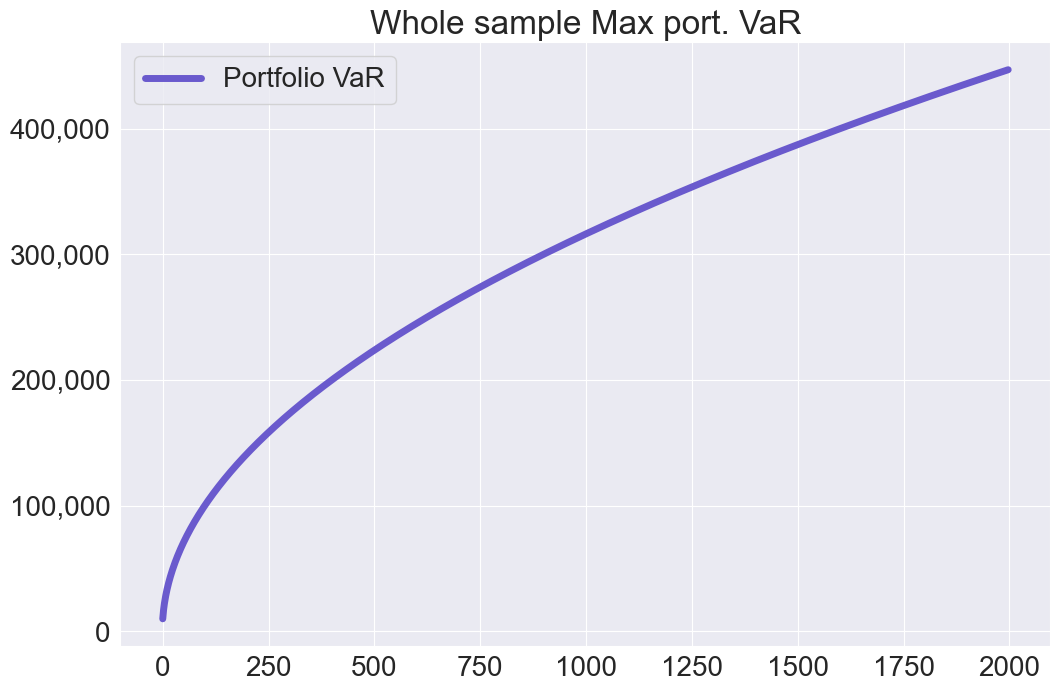

In [16]:
# VaR over time
## I have this code from a few projects and thought it would be cool to use here!

## Redoing the VaR chart for the portoflio above - Daily VaR
def VaR(data):
    cash = 10000   ## in case i accidendtaly overwrote this 
    
    ## I model the returns as a lognorm pppf as that is sorta good enough to capture tail risk
    ## I wont be diving into the stats of prob. dist fitting for fat tailed data here...
    cutPort = lognorm.ppf(0.05,returns(data).mean(),returns(data).std())

    var_T_Port = cash - cutPort


    var_Port = []


    for i in range(1,len(returns(data))):

        var_Port.append(np.round(var_T_Port * np.sqrt(i),2))

    plt.rcParams.update({'font.size': 20})
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,8),dpi=100)
    plt.plot(var_Port,'slateblue',linewidth = 5,label='Portfolio VaR')
    plt.title('Whole sample Max port. VaR')
    plt.legend(loc='best')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

print('SMA strat')
VaR(tf_strategy)
# VaR(mr_strategy)
# VaR(ar_strategy)
# VaR(buy_hold)

## Comments about the daily VaR above

These are almost identical curves.

This makes sense to me as the mean and std of each strategy is fairly similar. Therefore, when i fit the lognormal the corresponding values in the 95th percentile level are roughly the same.

A more refined approach would be to estiamted various densities, kernals, empirical, therocial disstributions and sample those for each strategy.

But i think that might be out of the scope of this CW...

# All Strats Plotted

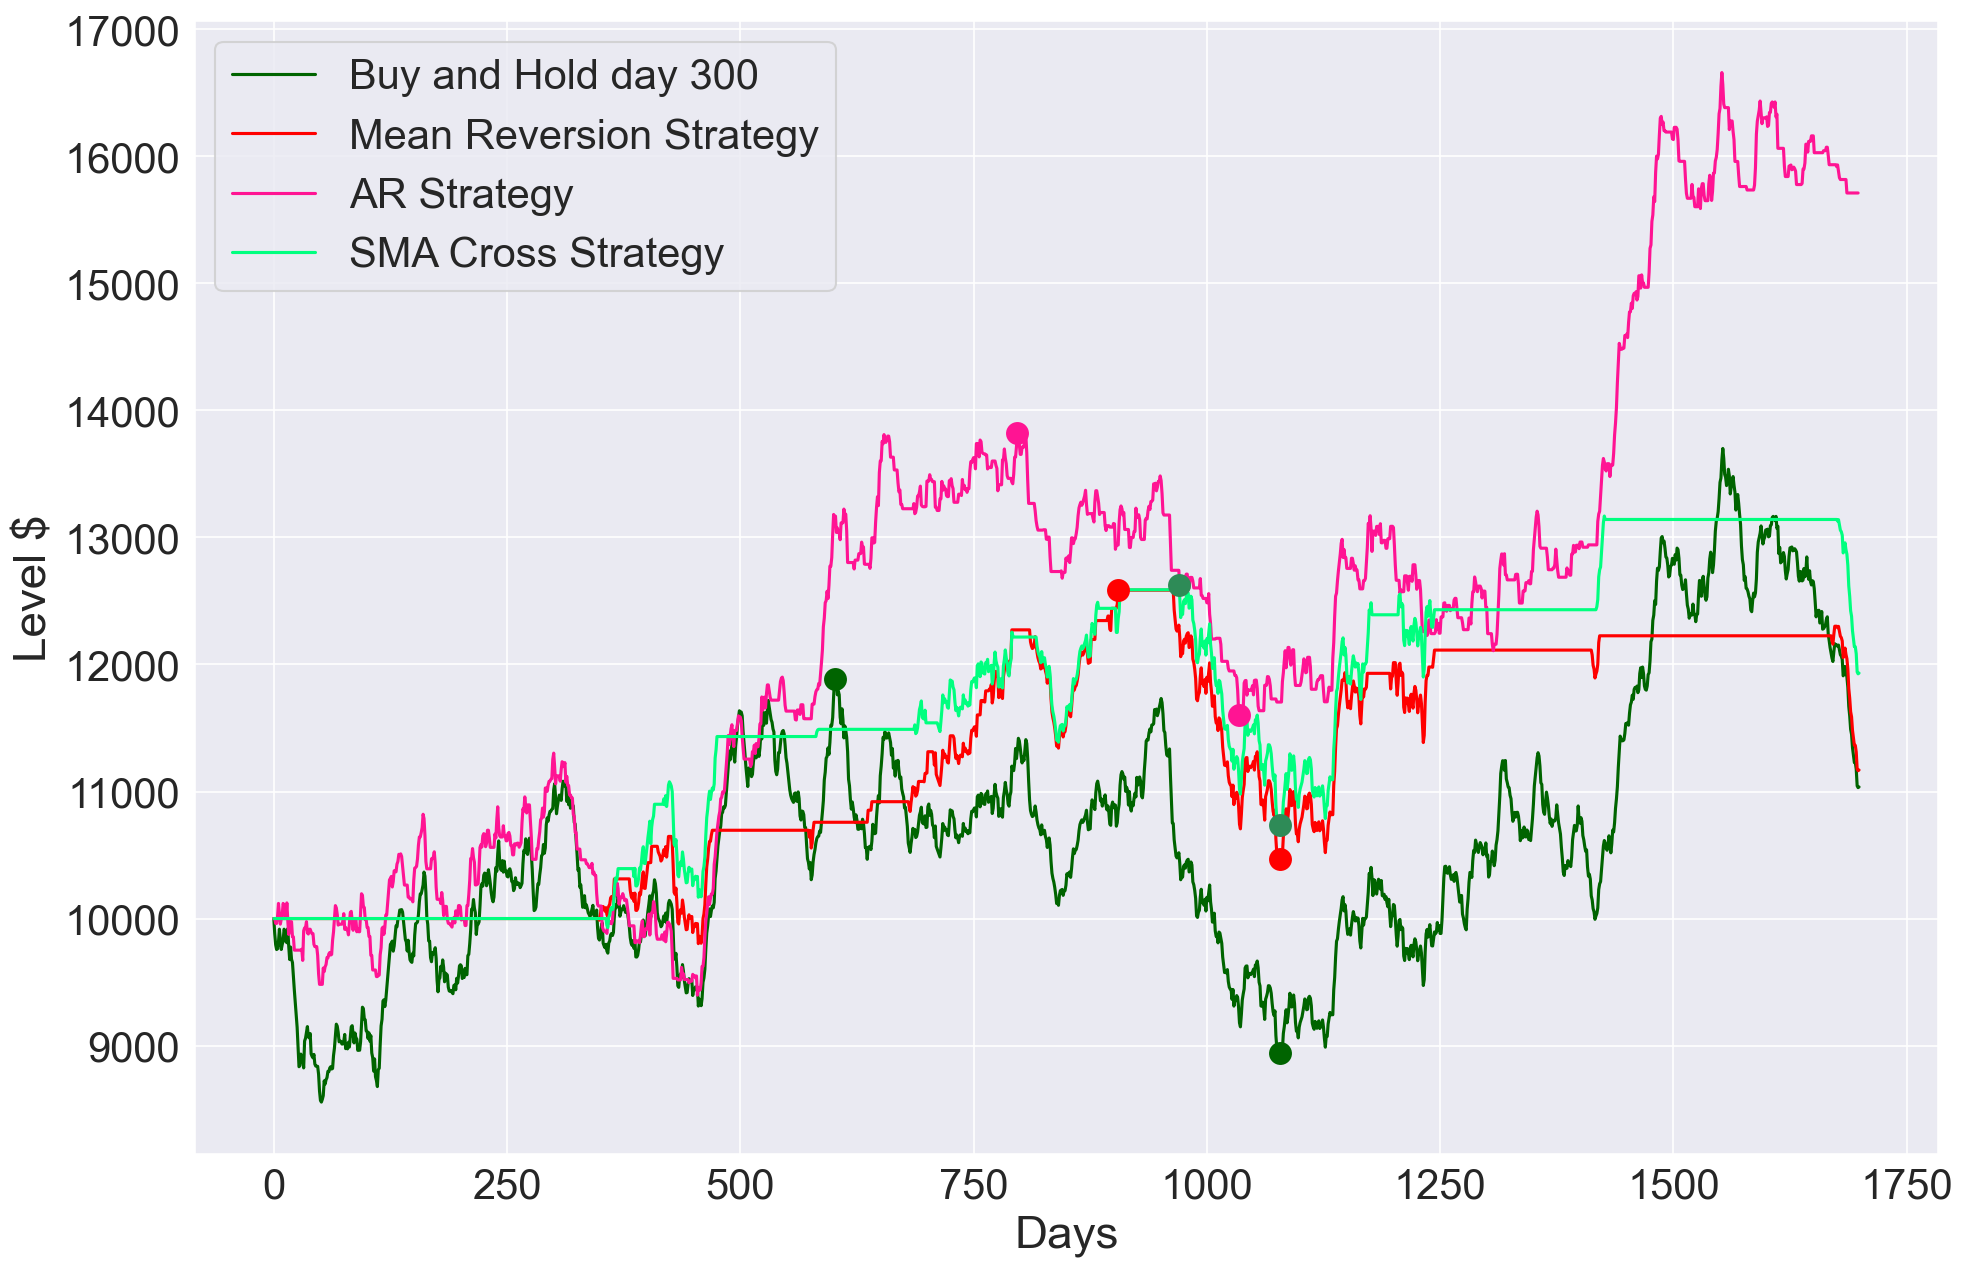

In [44]:
# Whole sample estimations

## Note this isnt a fair comparison as the buy and hold starts at day 300 but the others start at different points
## I'm using this as an eye ball check on the performance metrics above + maybe for the corusework

ar_plt = ar_strategy[300:]
mr_plt = mr_strategy[300:]
tf_plt = tf_strategy[300:]
bh_plt = cash*yt[300:]/yt[300]

plt.figure(figsize=(15,10),dpi=150)
plt.plot(bh_plt,color='darkgreen',label = 'Buy and Hold day 300')
# plt.plot(cash*yt/yt[0],color='darkgreen',label = 'Buy and Hold Day 0')
plt.plot(mr_plt,label='Mean Reversion Strategy',color='red')
plt.plot(ar_plt,label='AR Strategy',color='deeppink')
plt.plot(tf_plt,label='SMA Cross Strategy',color='springgreen')

# AR Max DD
i_ar = np.argmax(np.maximum.accumulate(ar_plt) - ar_plt) # end of the period
j_ar = np.argmax(ar_plt[:i_ar]) # start of period
plt.plot([i_ar, j_ar], [ar_plt[i_ar], ar_plt[j_ar]], 'o', color='deeppink', markersize=10)

# MR Max DD
i_mr = np.argmax(np.maximum.accumulate(mr_plt) - mr_plt) # end of the period
j_mr = np.argmax(mr_plt[:i_ar]) # start of period
plt.plot([i_mr, j_mr], [mr_plt[i_mr], mr_plt[j_mr]], 'o', color='red', markersize=10)

# SMA Max DD
i_tf = np.argmax(np.maximum.accumulate(tf_plt) - tf_plt) # end of the period
j_tf = np.argmax(tf_plt[:i_tf]) # start of period
plt.plot([i_tf, j_tf], [tf_plt[i_tf], tf_plt[j_tf]], 'o', color='seagreen', markersize=10)

# SMbuy and hold Max DD
i_bh = np.argmax(np.maximum.accumulate(bh_plt) - bh_plt) # end of the period
j_bh = np.argmax(bh_plt[:i_bh]) # start of period
plt.plot([i_bh, j_bh], [bh_plt[i_bh], bh_plt[j_bh]], 'o', color='darkgreen', markersize=10)



plt.xlabel('Days',fontsize=22)
plt.ylabel('Level $',fontsize=22)
plt.legend(loc='best')
plt.show()


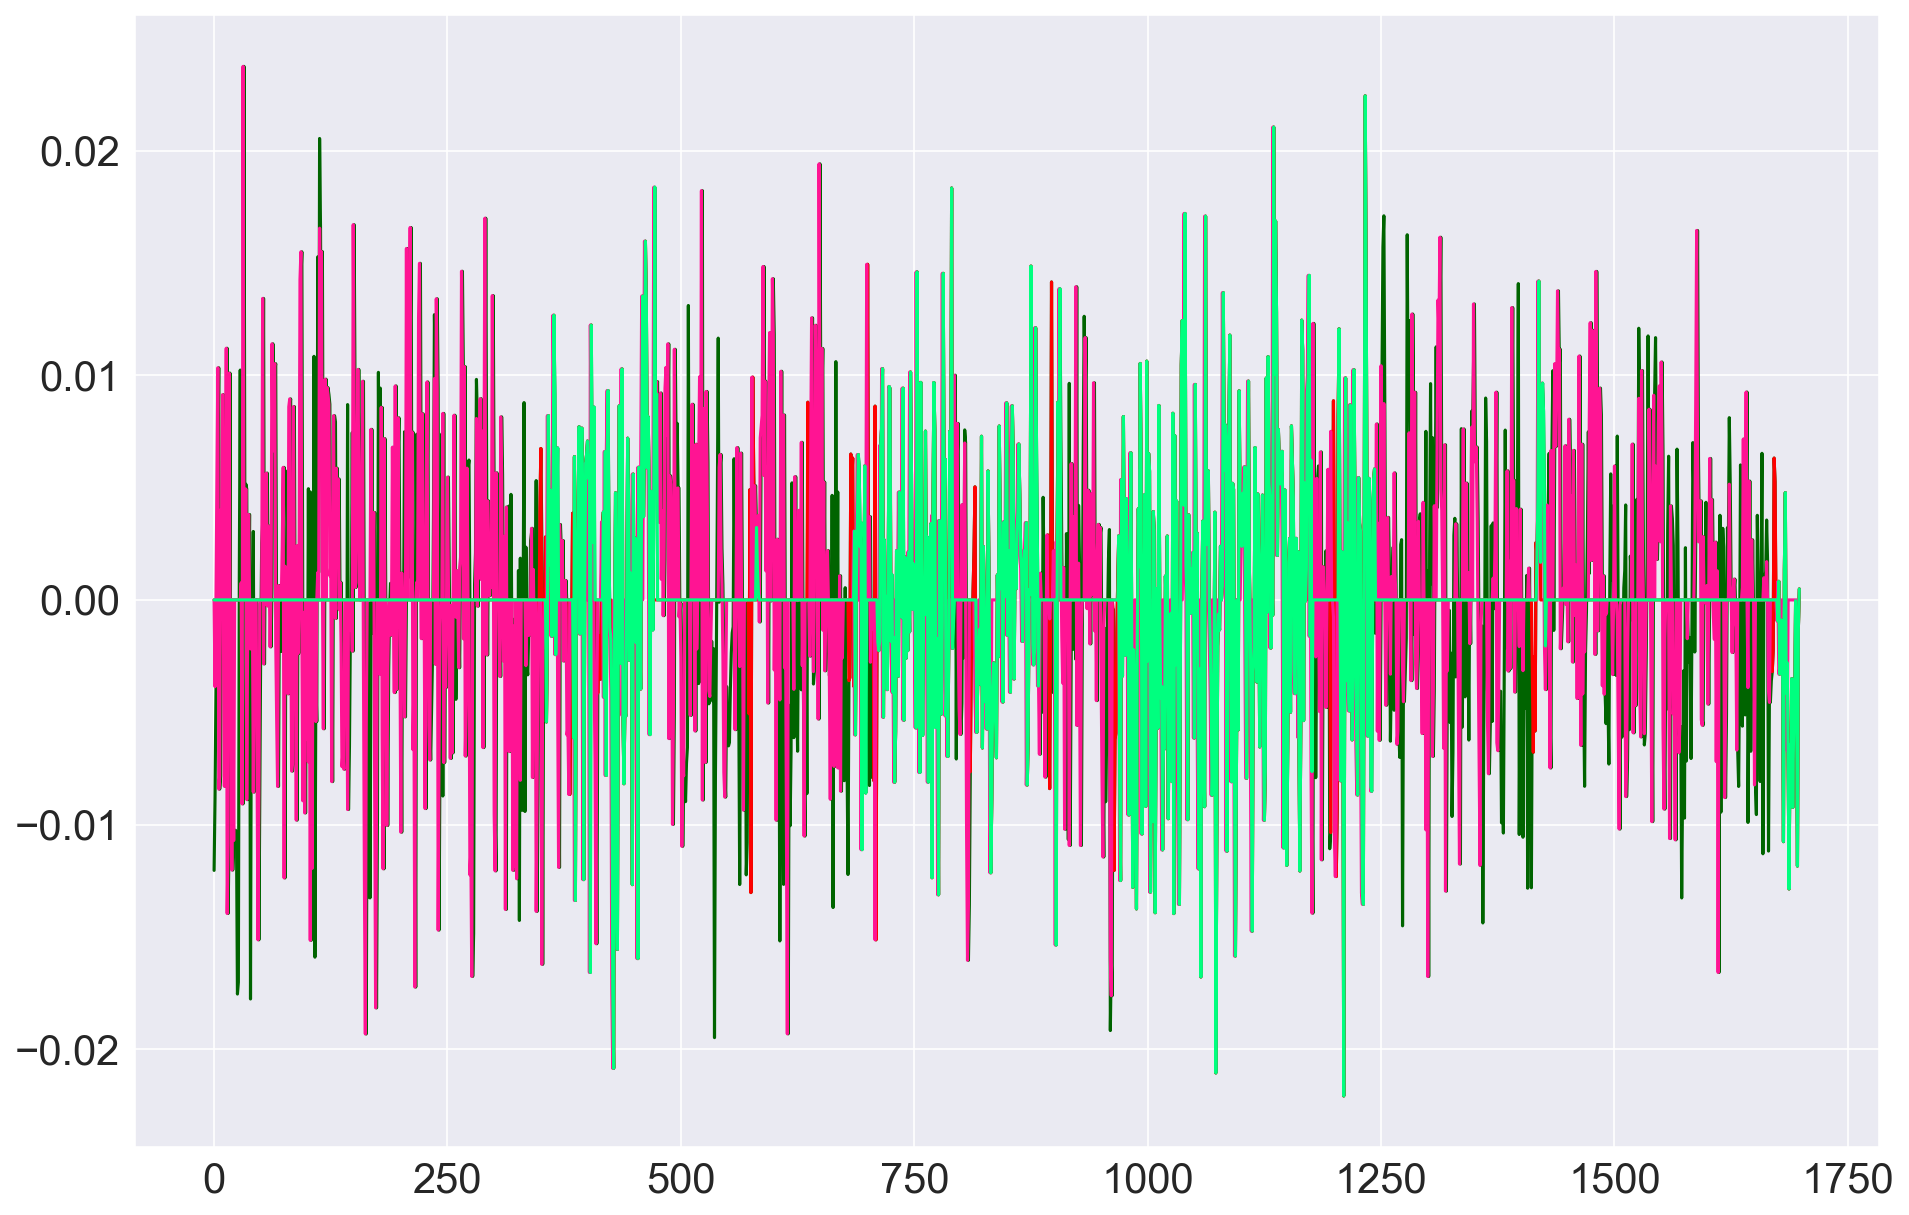

In [45]:
plt.figure(figsize=(15,10),dpi=150)
plt.plot(returns(bh_plt),color='darkgreen',label = 'Buy and Hold day 300')
# plt.plot(cash*yt/yt[0],color='darkgreen',label = 'Buy and Hold Day 0')
plt.plot(returns(mr_plt),label='Mean Reversion Strategy',color='red')
plt.plot(returns(ar_plt),label='AR Strategy',color='deeppink')
plt.plot(returns(tf_plt),label='SMA Cross Strategy',color='springgreen')

## Section 4
### Statistical Tests

5.5322154705319766e-05
0.0035854022126797056
T Statistic: 1.9771664790083523 P-Value 0.048160080264351854
T Statistic: 0.6902093080282885 P-Value 0.4901426945176518
T Statistic: 1.0930661694488815 P-Value 0.27449645391544236
T Statistic: 0.34284523788855104 P-Value 0.7317573033782687
 
AR Multiple SR adjustment 0.1376337629688379
Mean Reversion Multiple SR adjustment 0.8674603133815894
SMA Cross Multiple SR adjustment 0.6181272941501509
benchmark BH Multiple SR adjustment 0.9806988263023003
{'AR': 0.14448024079305555, 'SMA Cr': 0.823489361746327, 'MR': 1.4704280835529553}
(array([False, False, False]), array([0.14448024, 1.        , 0.82348936]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.14448024, 0.54899291, 0.54899291]), 0.016952427508441503, 0.016666666666666666)


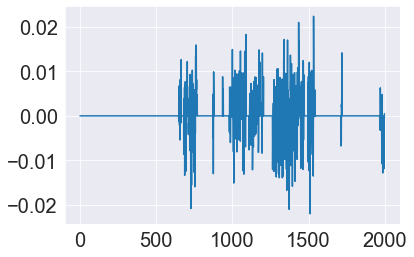

In [35]:
# Statisitcal tests
from statsmodels.stats.multitest import multipletests as mtt
import scipy.stats as stats
import operator
from collections import OrderedDict

## eyeball normality here. I feel confident enough with these metrics to assume returns are gaussian
## I did the below for one strategy however, they are all similar.
plt.plot(returns(mr_strategy))
print(returns(mr_strategy).mean())
print(returns(mr_strategy).std())



## Create a function to get sharpe ratios as t-statistics
def sharpe_t_test(data):
    """
    I think these should be computed over the whole sample...
    """
    t_stat= abs(sharpe(data)*sqrt(len(data)/252))       ## sharpe is the t-stat here by definition. The sharpe is annualized in the function *sharpe*
    pval = stats.t.sf(np.abs(t_stat), (len(data))-1)*2  ## the same formula as the Cambell Harvey paper, T=252 as we're annulizing the sharpe ratio too
    print('T Statistic:',t_stat, 'P-Value',pval)
    return pval

## Individual P values for sharpes
pval_ar = sharpe_t_test(ar_strategy)
pval_mr = sharpe_t_test(mr_strategy)
pval_tf = sharpe_t_test(tf_strategy)
pval_bh = sharpe_t_test(buy_hold[300:])

## Multiple testing SR adjustment
print(' ')
pval_MSR_ar = 1 - (1-pval_ar)**3
print('AR Multiple SR adjustment',pval_MSR_ar)
pval_MSR_mr = 1 - (1-pval_mr)**3
print('Mean Reversion Multiple SR adjustment',pval_MSR_mr)
pval_MSR_tf = 1 - (1-pval_tf)**3
print('SMA Cross Multiple SR adjustment',pval_MSR_tf)


p_val_arr = [pval_ar,pval_mr,pval_tf]

## Bonferonni
p_val_bon_dict = {'AR':pval_ar,'MR':pval_mr,'SMA Cr':pval_tf}


p_val_bon_dict_1 = {'AR':pval_ar,'MR':pval_mr,'SMA Cr':pval_tf}


def mtt_bon(dictionary):
    """
    takes a dictionary of p values, use name of the model / strat as the keys
    returns an ordered list of the p-values
    """
    dict_1 = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}
    dict_1.update((x, y*3) for x, y in dict_1.items())
    p_val_bon = {k: v for k, v in sorted(dict_1.items(), key=lambda item: item[1])}
    print(p_val_bon)
    return p_val_bon

mtt_bon(p_val_bon_dict)

## The scipy version of Bonferroni. I perfre my implementation as i can see the sames of the strategies too from the dict.
print(mtt(p_val_arr, method= 'bonferroni' ) )

## This gives the same values as mine so i'll use mine!

## Holm
### I couldnt get my own function to work (output with dict keys), so i've just used the scipy version!
def mtt_holm(dictionary):
    """
    takes a dictionary of p values, use name of the model / strat as the keys
    returns an ordered list of the p-values.
    The first element corresponds to the corresponding p-value in the holm method.
    """
    dict_2 = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}
    
    for k,v in dict_2.items():
        holm_p = []
        for i in range(len(dict_2)):
            holm_p.append(np.arange(i+1,0,-1)*v)
            
        dict_2[k] = [i[0] for i in holm_p]
        #dict_2.update((x, y*np.arange(i+1,0,-1)) for x, y in dict_2.items())
#     dict_2.update((x, y*np.arange(len(dict_2),0,-1)) for x, y in dict_2.items())

    #holm_p = sorted(dict_2.items(), key=operator.itemgetter(0), reverse=False  ) 
    print(holm_p)
    return holm_p
#mtt_holm(p_val_bon_dict)


## Scipy version of Holm
print(mtt(p_val_arr, method= 'holm' ,returnsorted=True)) 



In [19]:

"""
I think these should be computed over the whole sample...
"""
t_stat= 0.43*np.sqrt(580/12)    ## sharpe is the t-stat here by definition. The sharpe is annualized in the function *sharpe*
pval = stats.t.sf(np.abs(t_stat), (580)-1)*2  ## the same formula as the Cambell Harvey paper, T=252 as we're annulizing the sharpe ratio too
print('T Statistic:',t_stat, 'P-Value',pval)




T Statistic: 2.98945368476137 P-Value 0.002913407452773452


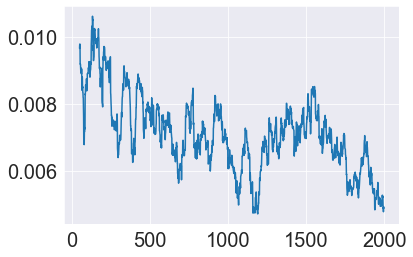

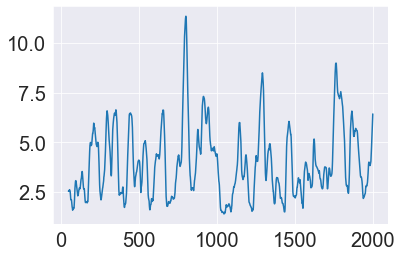

In [20]:
plt.plot(pd.DataFrame(returns(yt)).rolling(50).std() )
plt.show()

plt.plot(pd.DataFrame(yt).rolling(50).std() )

### Given the Bonferonni array, none of the p-values are significant at a 5% level.



# TO DO



# 1) If time allows - Exp smoothing algo
# 2) Nonesense algo - for fun try using spurious features to predict the level, maybe even just a random walk...